In [5]:
%reload_ext autoreload
%autoreload 2
import pynwb
import os

#DataJoint and DataJoint schema
import datajoint as dj
import numpy as np
import pandas as pd

## We also import a bunch of tables so that we can call them easily

from spyglass.common import (RawPosition, HeadDir, Speed, LinPos, StateScriptFile, VideoFile,
                                  DataAcquisitionDevice, CameraDevice, Probe,
                                  DIOEvents,
                                  ElectrodeGroup, Electrode, Raw, SampleCount,
                                  LFPSelection, LFP, LFPBandSelection, LFPBand,
                                  FirFilter,
                                  IntervalList,
                                  Lab, LabMember, LabTeam, Institution,
                                  BrainRegion,
                                  SensorData,
                                  Session, ExperimenterList,
                                  Subject,
                                  Task, TaskEpoch,
                                  Nwbfile, AnalysisNwbfile, NwbfileKachery, AnalysisNwbfileKachery,
                                  get_electrode_indices)
from spyglass.common.common_position import (PositionInfoParameters,IntervalPositionInfo,IntervalLinearizedPosition)
from spyglass.common.common_interval import interval_list_intersect



from plot_lfp import (get_x_y_list, get_speed,get_speed_timestamp, get_timestamps_and_data,get_electrode_ids,remove_dead_tet_chans,check_for_dead_probes,
                      checking_other_dead_tets,simple_plot,plot_overlay,plot_overlay_with_pos,plot_speed_versus_theta, find_overlapping_times,get_x_y_timestamp_list)

import re
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)



In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import statistics
from scipy.optimize import curve_fit
import math 
from scipy.stats import binom
import seaborn as sns
from scipy import stats
import matplotlib.patches as mpatches
from scipy.stats import beta
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

In [3]:
nwb_file_name = 'senor20201030_.nwb'

In [4]:
filename = r'/home/emonroe/Downloads/senor20201030_-Copy1.nwb_TrialsInfoByEpoch.ByTrial.csv'
trial_times = pd.read_csv(filename)
trial_times

,nwb_file_name,epoch,trial_number_by_epoch,leaf,stem,reward,poke_in_ts,reward_on_ts,reward_off_ts,poke_out_ts,...,p_rew_leaf4,p_rew_leaf5,p_rew_leaf6,decay_percent,p_rew_reset_leaf1,p_rew_reset_leaf2,p_rew_reset_leaf3,p_rew_reset_leaf4,p_rew_reset_leaf5,p_rew_reset_leaf6
0,senor20201030_.nwb,2,0,4,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,20,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,senor20201030_.nwb,2,1,3,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,20,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,senor20201030_.nwb,2,2,2,A,0,1.604078e+09,NaN,NaN,1.604078e+09,...,20,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,senor20201030_.nwb,2,3,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,20,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,senor20201030_.nwb,2,4,2,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,20,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,senor20201030_.nwb,14,175,1,A,0,1.604104e+09,NaN,NaN,1.604104e+09,...,50,20,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1256,senor20201030_.nwb,14,176,2,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,50,20,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1257,senor20201030_.nwb,14,177,1,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,50,20,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1258,senor20201030_.nwb,14,178,2,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,50,20,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
trial_times['stem_switch'] = trial_times['stem'].ne(trial_times['stem'].shift())

In [7]:
#trial_len = the time it took rat to get from last well to current well. 

trial_data=[]
trial_data.append('NaN')
for ix in range(len(trial_times)-1):
    trial_start = trial_times.iloc[ix].poke_out_ts
    trial_end = trial_times.iloc[ix+1].poke_in_ts
    trial_data.append(trial_end-trial_start)
trial_times['trial_len'] = trial_data

In [8]:


position_info = (IntervalPositionInfo() &
                 {'nwb_file_name': nwb_file_name,
                  'interval_list_name': 'pos 1 valid times',
                  'position_info_param_name': 'default'}
                ).fetch1_dataframe()
position_info





,head_position_x,head_position_y,head_orientation,head_velocity_x,head_velocity_y,head_speed
time,,,,,,
1.604078e+09,NaN,NaN,NaN,NaN,NaN,NaN
1.604078e+09,NaN,NaN,NaN,NaN,NaN,NaN
1.604078e+09,NaN,NaN,NaN,NaN,NaN,NaN
1.604078e+09,NaN,NaN,NaN,NaN,NaN,NaN
1.604078e+09,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
1.604079e+09,96.2465,68.4265,1.892547,-18.510226,39.833951,43.924618
1.604079e+09,96.1395,70.3525,1.783228,-13.011806,39.301131,41.399107
1.604079e+09,96.1930,72.3320,1.723446,-8.684986,37.011240,38.016587


In [9]:
e2 = trial_times[trial_times.epoch==2]

In [10]:
# trial_timestamps =[]
# for ix in range(len(trial_times)-1):
#     trial_start = trial_times.iloc[ix].poke_out_ts
#     trial_end = trial_times.iloc[ix+1].poke_in_ts
#     trial_timestamps.append([trial_start,trial_end])


trial_timestamps =[]
for ix in range(len(e2)-1):
    trial_start = e2.iloc[ix].poke_out_ts
    trial_end = e2.iloc[ix+1].poke_in_ts
    trial_timestamps.append([trial_start,trial_end])
    
    
avg_speed_per_trial=[]
avg_speed_per_trial.append('NaN')
max_speed_per_trial=[]
max_speed_per_trial.append('NaN')
min_speed_per_trial=[]
min_speed_per_trial.append('NaN')
for ix in range(len(trial_timestamps)):
    speed_x,speed_y = get_speed_timestamp(trial_timestamps[ix][0],trial_timestamps[ix][1],position_info)
    avg_speed_per_trial.append(statistics.mean(speed_y))
    max_speed_per_trial.append(speed_y.max())
    min_speed_per_trial.append(speed_y.min())
                               




In [11]:
e2['avg_speed_per_trial'] =avg_speed_per_trial
e2['max_speed_per_trial'] =max_speed_per_trial
e2['min_speed_per_trial'] =min_speed_per_trial




In [12]:
trial_times

,nwb_file_name,epoch,trial_number_by_epoch,leaf,stem,reward,poke_in_ts,reward_on_ts,reward_off_ts,poke_out_ts,...,p_rew_leaf6,decay_percent,p_rew_reset_leaf1,p_rew_reset_leaf2,p_rew_reset_leaf3,p_rew_reset_leaf4,p_rew_reset_leaf5,p_rew_reset_leaf6,stem_switch,trial_len
0,senor20201030_.nwb,2,0,4,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN
1,senor20201030_.nwb,2,1,3,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2.156
2,senor20201030_.nwb,2,2,2,A,0,1.604078e+09,NaN,NaN,1.604078e+09,...,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,4.84
3,senor20201030_.nwb,2,3,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2.226
4,senor20201030_.nwb,2,4,2,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,3.727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,senor20201030_.nwb,14,175,1,A,0,1.604104e+09,NaN,NaN,1.604104e+09,...,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2.73
1256,senor20201030_.nwb,14,176,2,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2.67
1257,senor20201030_.nwb,14,177,1,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2.462
1258,senor20201030_.nwb,14,178,2,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2.298


In [13]:
# obj = ['epoch','stem','leaf']
halflife=20
# trial_times['rew_rate'] =trial_times.groupby(obj)[['reward']].transform(lambda x: x.rolling(10, 1).mean())
# trial_times['rew_rate_ewm'] =trial_times.groupby(obj)[['reward']].transform(lambda x: x.ewm(10, 1).mean())
obj = ['epoch','stem','leaf']
trial_times['rew_rate_ewm_leaf'] =trial_times.groupby(obj)[['reward']].apply(lambda x: x.ewm(halflife).mean())
obj = ['epoch','stem']
trial_times['rew_rate_ewm_stem'] =trial_times.groupby(obj)[['reward']].apply(lambda x: x.ewm(halflife).mean())
obj = ['epoch']
trial_times['rew_rate_ewm_epoch'] =trial_times.groupby(obj)[['reward']].apply(lambda x: x.ewm(halflife).mean())

In [14]:
trial_times

,nwb_file_name,epoch,trial_number_by_epoch,leaf,stem,reward,poke_in_ts,reward_on_ts,reward_off_ts,poke_out_ts,...,p_rew_reset_leaf2,p_rew_reset_leaf3,p_rew_reset_leaf4,p_rew_reset_leaf5,p_rew_reset_leaf6,stem_switch,trial_len,rew_rate_ewm_leaf,rew_rate_ewm_stem,rew_rate_ewm_epoch
0,senor20201030_.nwb,2,0,4,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,NaN,NaN,NaN,NaN,NaN,True,NaN,0.000000,0.000000,0.000000
1,senor20201030_.nwb,2,1,3,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,NaN,NaN,NaN,NaN,NaN,False,2.156,0.000000,0.000000,0.000000
2,senor20201030_.nwb,2,2,2,A,0,1.604078e+09,NaN,NaN,1.604078e+09,...,NaN,NaN,NaN,NaN,NaN,True,4.84,0.000000,0.000000,0.000000
3,senor20201030_.nwb,2,3,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,NaN,NaN,NaN,NaN,NaN,False,2.226,1.000000,0.512195,0.268583
4,senor20201030_.nwb,2,4,2,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,NaN,NaN,NaN,NaN,NaN,False,3.727,0.512195,0.682791,0.429477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,senor20201030_.nwb,14,175,1,A,0,1.604104e+09,NaN,NaN,1.604104e+09,...,NaN,NaN,NaN,NaN,NaN,False,2.73,0.484233,0.423502,0.392555
1256,senor20201030_.nwb,14,176,2,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,NaN,NaN,NaN,NaN,NaN,False,2.67,0.442383,0.452865,0.421487
1257,senor20201030_.nwb,14,177,1,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,NaN,NaN,NaN,NaN,NaN,False,2.462,0.516675,0.480641,0.449039
1258,senor20201030_.nwb,14,178,2,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,NaN,NaN,NaN,NaN,NaN,False,2.298,0.477458,0.506923,0.475280


Text(0, 0.5, 'count')

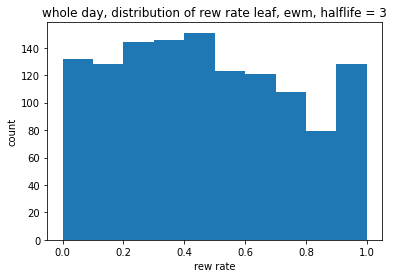

In [30]:
plt.hist(trial_times.rew_rate_ewm_leaf)
plt.title(f'whole day, distribution of rew rate leaf, ewm, halflife = {halflife}')
plt.xlabel('rew rate')
plt.ylabel('count')

In [47]:
e2 = trial_times[trial_times.epoch==2]

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     14.55
Date:                Mon, 27 Jun 2022   Prob (F-statistic):           0.000188
Time:                        13:31:21   Log-Likelihood:                -284.58
No. Observations:                 179   AIC:                             573.2
Df Residuals:                     177   BIC:                             579.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.7734      0.205     18.373      0.0

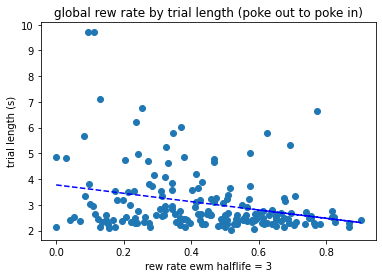

In [48]:
plt.scatter(e2.rew_rate_ewm_epoch[1:],e2.trial_len[1:])
plt.title('global rew rate by trial length (poke out to poke in)')
plt.xlabel(f'rew rate ewm halflife = {halflife}')
plt.ylabel('trial length (s)')



x=(e2.rew_rate_ewm_epoch[1:]).tolist()
y=(e2.trial_len[1:]).tolist()
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"b--")
X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     8.229
Date:                Mon, 27 Jun 2022   Prob (F-statistic):            0.00462
Time:                        13:32:43   Log-Likelihood:                -607.78
No. Observations:                 179   AIC:                             1220.
Df Residuals:                     177   BIC:                             1226.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         40.3374      1.249     32.286      0.0

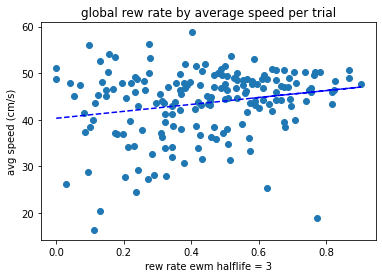

In [49]:
plt.scatter(e2.rew_rate_ewm_epoch[1:],e2.avg_speed_per_trial[1:])
plt.title('global rew rate by average speed per trial')
plt.xlabel(f'rew rate ewm halflife = {halflife}')
plt.ylabel('avg speed (cm/s)')



x=(e2.rew_rate_ewm_epoch[1:]).tolist()
y=(e2.avg_speed_per_trial[1:]).tolist()
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"b--")
X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.133
Date:                Tue, 28 Jun 2022   Prob (F-statistic):              0.289
Time:                        11:24:19   Log-Likelihood:                -611.27
No. Observations:                 179   AIC:                             1227.
Df Residuals:                     177   BIC:                             1233.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         42.6770      1.002     42.602      0.0

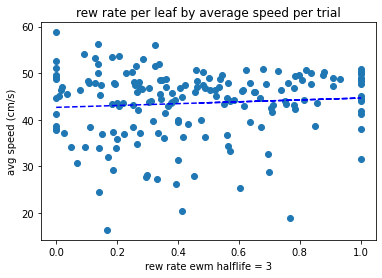

In [224]:
#leaf rew rate, avg speed

x=(e2.rew_rate_ewm_leaf[1:]).tolist()
y=(e2.avg_speed_per_trial[1:]).tolist()

plt.scatter(x,y)
plt.title('rew rate per leaf by average speed per trial')
plt.xlabel(f'rew rate ewm halflife = {halflife}')
plt.ylabel('avg speed (cm/s)')



# x=(e2.avg_speed_per_trial[1:]).tolist()
# y=(e2.rew_rate_ewm_leaf[1:]).tolist()
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"b--")
X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     4.007
Date:                Mon, 27 Jun 2022   Prob (F-statistic):             0.0468
Time:                        13:50:08   Log-Likelihood:                 11.126
No. Observations:                 179   AIC:                            -18.25
Df Residuals:                     177   BIC:                            -11.88
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2405      0.102      2.351      0.0

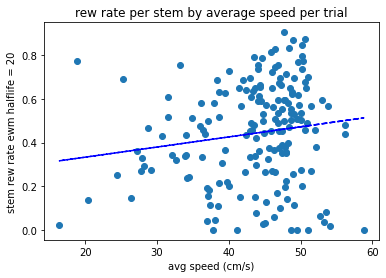

In [58]:
#stem rew rate, avg speed
plt.scatter(e2.avg_speed_per_trial[1:],e2.rew_rate_ewm_stem[1:])
plt.title('rew rate per stem by average speed per trial')
plt.ylabel(f'stem rew rate ewm halflife = {halflife}')
plt.xlabel('avg speed (cm/s)')



x=(e2.avg_speed_per_trial[1:]).tolist()
y=(e2.rew_rate_ewm_stem[1:]).tolist()
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"b--")
X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.1632
Date:                Mon, 06 Jun 2022   Prob (F-statistic):              0.687
Time:                        16:27:42   Log-Likelihood:                -515.11
No. Observations:                 179   AIC:                             1034.
Df Residuals:                     177   BIC:                             1041.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         72.1472      0.744     96.908      0.0

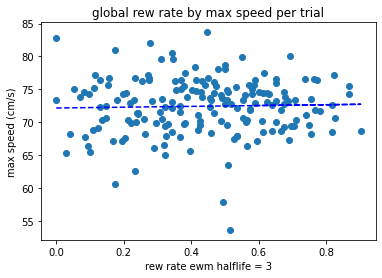

In [260]:
#epoch rew rate, max speed 
plt.scatter(e2.rew_rate_ewm_epoch[1:],e2.max_speed_per_trial[1:])
plt.title('global rew rate by max speed per trial')
plt.xlabel(f'rew rate ewm halflife = {halflife}')
plt.ylabel('max speed (cm/s)')



x=(e2.rew_rate_ewm_epoch[1:]).tolist()
y=(e2.max_speed_per_trial[1:]).tolist()
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"b--")
X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9863
Date:                Mon, 06 Jun 2022   Prob (F-statistic):              0.322
Time:                        16:27:42   Log-Likelihood:                -490.12
No. Observations:                 179   AIC:                             984.2
Df Residuals:                     177   BIC:                             990.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9387      0.647      7.628      0.0

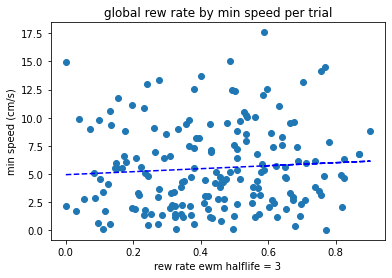

In [261]:
#epoch rew rate, min speed 
plt.scatter(e2.rew_rate_ewm_epoch[1:],e2.min_speed_per_trial[1:])
plt.title('global rew rate by min speed per trial')
plt.xlabel(f'rew rate ewm halflife = {halflife}')
plt.ylabel('min speed (cm/s)')



x=(e2.rew_rate_ewm_epoch[1:]).tolist()
y=(e2.min_speed_per_trial[1:]).tolist()
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"b--")
X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.2008
Date:                Tue, 07 Jun 2022   Prob (F-statistic):              0.655
Time:                        11:09:30   Log-Likelihood:                -35.775
No. Observations:                 179   AIC:                             75.55
Df Residuals:                     177   BIC:                             81.92
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6139      0.375      1.639      0.1

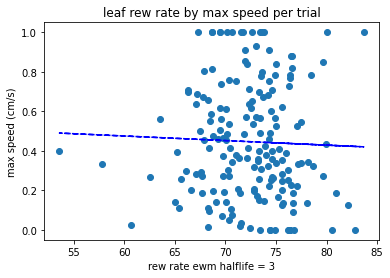

In [349]:
#leaf rew rate, max speed 

x =(e2.max_speed_per_trial[1:]).tolist()
y= (e2.rew_rate_ewm_leaf[1:]).tolist()
# plt.scatter(e2.rew_rate_ewm_leaf[1:],e2.max_speed_per_trial[1:])
plt.scatter(x,y)
plt.title('leaf rew rate by max speed per trial')
plt.xlabel(f'rew rate ewm halflife = {halflife}')
plt.ylabel('max speed (cm/s)')



# x=(e2.rew_rate_ewm_leaf[1:]).tolist()
# y=
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"b--")
X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.6851
Date:                Tue, 07 Jun 2022   Prob (F-statistic):              0.409
Time:                        11:13:36   Log-Likelihood:                -490.27
No. Observations:                 179   AIC:                             984.5
Df Residuals:                     177   BIC:                             990.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.1664      0.510     10.139      0.0

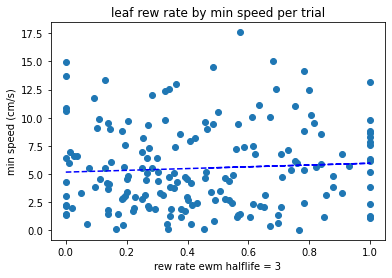

In [354]:
#1 epoch, min speed vs leaf avg 
x=(e2.rew_rate_ewm_leaf[1:]).tolist()
y=(e2.min_speed_per_trial[1:]).tolist()


plt.scatter(x,y)
plt.title('leaf rew rate by min speed per trial')
plt.xlabel(f'rew rate ewm halflife = {halflife}')
plt.ylabel('min speed (cm/s)')




z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"b--")
X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.5760
Date:                Mon, 27 Jun 2022   Prob (F-statistic):              0.449
Time:                        13:48:03   Log-Likelihood:                 9.4134
No. Observations:                 179   AIC:                            -14.83
Df Residuals:                     177   BIC:                            -8.452
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6628      0.291      2.278      0.0

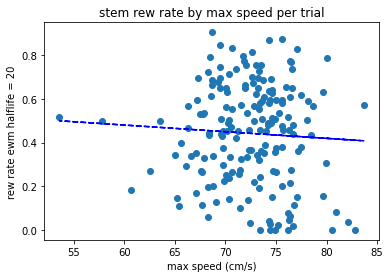

In [57]:
#leaf rew rate, max speed 

x =(e2.max_speed_per_trial[1:]).tolist()
y= (e2.rew_rate_ewm_stem[1:]).tolist()
# plt.scatter(e2.rew_rate_ewm_leaf[1:],e2.max_speed_per_trial[1:])
plt.scatter(x,y)
plt.title('stem rew rate by max speed per trial')
plt.ylabel(f'rew rate ewm halflife = {halflife}')
plt.xlabel('max speed (cm/s)')



# x=(e2.rew_rate_ewm_leaf[1:]).tolist()
# y=
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"b--")
X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

# now we can get a little mroe complicated. instead of looking at all poke in to poke out times, lets look at one times when rat is running

In [265]:
#that sounds meh, im going to scale up first. 


In [41]:
epoch_pos = [[2, 1],[4,8],[6 , 10],[8 ,12],[10,14],[12,3],[14,5]]

#get the segment switch times in the same way as before 

list_seg_switch=[]

#for each epoch
for epoch in range(2,16,2):
    #seperate 1 epoch
    #load the trial data for each epoch individually just to compare trial times and pos times which are by the epoch 
    trial_data_sesh = trial_times[trial_times.epoch==epoch]
    
    #get the start/stop trial times
    trial_data=[]
    #for each session, find the poke in and out times, save those to a list
    for ix in range(1,len(trial_data_sesh)):
        trial_start = trial_data_sesh.iloc[ix-1].poke_out_ts
        trial_end = trial_data_sesh.iloc[ix].poke_in_ts
        trial_data.append([trial_start, trial_end])
    
    #use the epoch pos from above to get the corresponding pos # for the epoch, frm the pic alison send to me
    #if this wasnt correct, the code would break so thats a relief! 
    
    for ix in range(len(epoch_pos)):
        if epoch_pos[ix][0]==epoch:
            pos_num = epoch_pos[ix][1]
    
    #get the position and linearized position info for that epoch 
    position_info = (IntervalPositionInfo() &
                     {'nwb_file_name': nwb_file_name,
                      'interval_list_name': f'pos {pos_num} valid times',
                      'position_info_param_name': 'default'}
                    ).fetch1_dataframe()
    # position_info

    linear_position_df= (IntervalLinearizedPosition() &
                         {'position_info_param_name': 'default',
                          'nwb_file_name': nwb_file_name,
                          'interval_list_name': f'pos {pos_num} valid times',
                          'track_graph_name': 'senor20201030',
                          'linearization_param_name': 'default',
                         }).fetch1_dataframe()
    # linear_position_df
    #get the track segment switch times from linearized position
    linear_position_df['track_segment_id_switch'] = linear_position_df['track_segment_id'].ne(linear_position_df['track_segment_id'].shift())
    
    seg_switch_times = linear_position_df[linear_position_df.track_segment_id_switch==True].index
    
    #find the segement switch times for each trial individually 
    trials_seg_switch_times = []
    for ix in range(len(trial_data)):
        #one inidividual trials start and end times 
        trial_start = trial_data[ix][0]
        trial_end = trial_data[ix][1]
        #find the segment switch time that falls within those trial times 
        switch_time_ind_s = seg_switch_times>=trial_start
        switch_time_ind_e = seg_switch_times<=trial_end
        trial_switch_times = seg_switch_times[switch_time_ind_s & switch_time_ind_e]
        #make it into a new list- for each trial, each now has a list of 1+ segment switch times  
        trials_seg_switch_times.append(trial_switch_times)
        
    #add a 0 to make it the same length as the df 
    list_seg_switch.append(0)
# add these segment switch times to a new list, which will be added to the total df. this might be a little redundant. 
    for ix in range(len(trials_seg_switch_times)):
        seg_switch_times = trials_seg_switch_times[ix]
        if len(seg_switch_times)==1:
            list_seg_switch.append([seg_switch_times[0]])
        else: 
            list_seg_switch.append(seg_switch_times[0:].tolist())

In [207]:
trial_times

,nwb_file_name,epoch,trial_number_by_epoch,leaf,stem,reward,poke_in_ts,reward_on_ts,reward_off_ts,poke_out_ts,...,trial_len,rew_rate_ewm_leaf,rew_rate_ewm_stem,rew_rate_ewm_epoch,seg_switch_times,avg_speed_per_trial,max_speed_per_trial,min_speed_per_trial,speed_all_trial,trial_speeds_1s
0,senor20201030_.nwb,2,0,4,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,NaN,0.000000,0.000000,0.000000,0,NaN,NaN,NaN,NaN,[0]
1,senor20201030_.nwb,2,1,3,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,2.156,0.000000,0.000000,0.000000,[1604078259.6768906],51.078441,82.84474,14.939608,"[15.062713307249425, 19.321927234376464, 24.02...","[[42.95127214991963, 43.86733681223068, 43.580..."
2,senor20201030_.nwb,2,2,2,A,0,1.604078e+09,NaN,NaN,1.604078e+09,...,4.84,0.000000,0.000000,0.000000,"[1604078268.4768033, 1604078268.810136, 160407...",48.655067,73.394483,2.184796,"[16.376759798195184, 22.196654189333294, 28.52...",[0]
3,senor20201030_.nwb,2,3,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,2.226,1.000000,0.512195,0.268583,[1604078279.2767003],49.832956,71.575427,9.793412,"[9.793411570687521, 13.531200487296626, 18.017...","[[32.57568279012766, 36.10792852734244, 38.296..."
4,senor20201030_.nwb,2,4,2,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,3.727,0.512195,0.682791,0.429477,[1604078292.4099002],33.240799,72.046607,1.453074,"[4.325741268658773, 6.150507068352855, 8.32426...","[[22.56292524021044, 24.788513641690827, 28.07..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,senor20201030_.nwb,14,175,1,A,0,1.604104e+09,NaN,NaN,1.604104e+09,...,2.73,0.484233,0.423502,0.392555,[1604103536.0823658],42.377209,69.27256,3.97578,"[11.78316489530877, 15.58515467318779, 19.1058...","[[31.664944623166665, 28.159526985593736, 25.8..."
1256,senor20201030_.nwb,14,176,2,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,2.67,0.442383,0.452865,0.421487,[1604103539.3156853],42.638762,66.655695,5.594969,"[5.594969397402997, 8.612097514627141, 12.4385...","[[19.276576340031575, 21.62404427356428, 24.83..."
1257,senor20201030_.nwb,14,177,1,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,2.462,0.516675,0.480641,0.449039,[1604103545.7489443],46.99723,68.021411,15.905849,"[15.90584921995597, 20.113960355128164, 24.225...","[[29.21387013494309, 29.84098187186636, 30.496..."
1258,senor20201030_.nwb,14,178,2,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,2.298,0.477458,0.506923,0.475280,[1604103552.8488734],48.893069,68.078626,10.117551,"[10.11755100990477, 13.7862750854686, 18.08672...","[[43.51803373158746, 45.99597855934353, 48.045..."


In [268]:
len(list_seg_switch)

1260

In [43]:
trial_times['seg_switch_times']= list_seg_switch

In [44]:
#first very scaled up version of things. make these empty lists, 
#choose an epoch, get the corresponsing pos. get trial times- just poke in and out times. 
#then mask the position data by those trial times and save them to the list. 

avg_speed_per_trial=[]
avg_speed_per_trial.append('NaN')
max_speed_per_trial=[]
max_speed_per_trial.append('NaN')
min_speed_per_trial=[]
min_speed_per_trial.append('NaN')
speed_all_trial=[]
speed_all_trial.append('NaN')
for epoch in range(2,16,2):
    #seperate 1 epoch
    #load the trial data for each epoch individually just to compare trial times and pos times which are by the epoch 
    trial_data_sesh = trial_times[trial_times.epoch==epoch]
    
    #get the start/stop trial times
    trial_data=[]
    #for each session, find the poke in and out times, save those to a list
    for ix in range(1,len(trial_data_sesh)):
        trial_start = trial_data_sesh.iloc[ix-1].poke_out_ts
        trial_end = trial_data_sesh.iloc[ix].poke_in_ts
        trial_data.append([trial_start, trial_end])
    
    #use the epoch pos from above to get the corresponding pos # for the epoch, frm the pic alison send to me
    #if this wasnt correct, the code would break so thats a relief! 
    
    for ix in range(len(epoch_pos)):
        if epoch_pos[ix][0]==epoch:
            pos_num = epoch_pos[ix][1]
    
    #get the position and linearized position info for that epoch 
    position_info = (IntervalPositionInfo() &
                     {'nwb_file_name': nwb_file_name,
                      'interval_list_name': f'pos {pos_num} valid times',
                      'position_info_param_name': 'default'}
                    ).fetch1_dataframe()


    for ix in range(len(trial_data)):
        speed_x,speed_y = get_speed_timestamp(trial_data[ix][0],trial_data[ix][1],position_info)
        avg_speed_per_trial.append(statistics.mean(speed_y))
        max_speed_per_trial.append(speed_y.max())
        min_speed_per_trial.append(speed_y.min())
        speed_y_temp=[]
        for speed in range(len(speed_y)):
            speed_y_temp.append(speed_y.iloc[speed])
        speed_all_trial.append(speed_y_temp)

    avg_speed_per_trial.append('NaN')
    max_speed_per_trial.append('NaN')
    min_speed_per_trial.append('NaN')
    speed_all_trial.append('NaN')

1261

In [45]:
#added an extra Nan but cant put them first because of some reason that i dont remember...
avg_speed_per_trial = (avg_speed_per_trial[0:-1])
max_speed_per_trial = (max_speed_per_trial[0:-1])
min_speed_per_trial = (min_speed_per_trial[0:-1])
speed_all_trial = (speed_all_trial[0:-1])

In [46]:
trial_times['avg_speed_per_trial'] = avg_speed_per_trial
trial_times['max_speed_per_trial'] = max_speed_per_trial
trial_times['min_speed_per_trial'] = min_speed_per_trial
trial_times['speed_all_trial'] = speed_all_trial



In [59]:
trial_times

,nwb_file_name,epoch,trial_number_by_epoch,leaf,stem,reward,poke_in_ts,reward_on_ts,reward_off_ts,poke_out_ts,...,stem_switch,trial_len,rew_rate_ewm_leaf,rew_rate_ewm_stem,rew_rate_ewm_epoch,seg_switch_times,avg_speed_per_trial,max_speed_per_trial,min_speed_per_trial,speed_all_trial
0,senor20201030_.nwb,2,0,4,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,True,NaN,0.000000,0.000000,0.000000,0,NaN,NaN,NaN,NaN
1,senor20201030_.nwb,2,1,3,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,False,2.156,0.000000,0.000000,0.000000,[1604078259.6768906],51.078441,82.84474,14.939608,"[15.062713307249425, 19.321927234376464, 24.02..."
2,senor20201030_.nwb,2,2,2,A,0,1.604078e+09,NaN,NaN,1.604078e+09,...,True,4.84,0.000000,0.000000,0.000000,"[1604078268.4768033, 1604078268.810136, 160407...",48.655067,73.394483,2.184796,"[16.376759798195184, 22.196654189333294, 28.52..."
3,senor20201030_.nwb,2,3,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,False,2.226,1.000000,0.512195,0.268583,[1604078279.2767003],49.832956,71.575427,9.793412,"[9.793411570687521, 13.531200487296626, 18.017..."
4,senor20201030_.nwb,2,4,2,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,False,3.727,0.512195,0.682791,0.429477,[1604078292.4099002],33.240799,72.046607,1.453074,"[4.325741268658773, 6.150507068352855, 8.32426..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,senor20201030_.nwb,14,175,1,A,0,1.604104e+09,NaN,NaN,1.604104e+09,...,False,2.73,0.484233,0.423502,0.392555,[1604103536.0823658],42.377209,69.27256,3.97578,"[11.78316489530877, 15.58515467318779, 19.1058..."
1256,senor20201030_.nwb,14,176,2,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,False,2.67,0.442383,0.452865,0.421487,[1604103539.3156853],42.638762,66.655695,5.594969,"[5.594969397402997, 8.612097514627141, 12.4385..."
1257,senor20201030_.nwb,14,177,1,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,False,2.462,0.516675,0.480641,0.449039,[1604103545.7489443],46.99723,68.021411,15.905849,"[15.90584921995597, 20.113960355128164, 24.225..."
1258,senor20201030_.nwb,14,178,2,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,False,2.298,0.477458,0.506923,0.475280,[1604103552.8488734],48.893069,68.078626,10.117551,"[10.11755100990477, 13.7862750854686, 18.08672..."


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     5.860
Date:                Mon, 06 Jun 2022   Prob (F-statistic):             0.0156
Time:                        16:27:45   Log-Likelihood:                 151.77
No. Observations:                1164   AIC:                            -299.5
Df Residuals:                    1162   BIC:                            -289.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3661      0.045      8.165      0.0

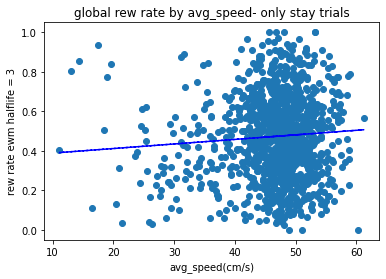

In [273]:
x=[]
y=[]
for ix in range(len(trial_times)):
    if trial_times.iloc[ix].max_speed_per_trial !='NaN':
        if trial_times.iloc[ix].stem_switch==False:
            x.append(trial_times.iloc[ix].avg_speed_per_trial)
            y.append(trial_times.iloc[ix].rew_rate_ewm_epoch)
plt.scatter(x,y)
plt.title('global rew rate by avg_speed- only stay trials')
plt.xlabel('avg_speed(cm/s)')
plt.ylabel(f'rew rate ewm halflife = {halflife}')


z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"b--")
X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

In [21]:
trial_times['bout_num'] = trial_times['stem'].ne(trial_times['stem'].shift()).cumsum()



In [22]:
trial_times['bout_num'] = trial_times['stem'].ne(trial_times['stem'].shift()).cumsum()


#adding the length of each bout 
bout_len_lst=[]
for ix in range(1,(trial_times.bout_num.max()+1)):
    bout_len = len(trial_times[trial_times.bout_num == ix])
    bout_len_lst.append((np.ones(bout_len)*bout_len).tolist())
bout_len_list = [item for sublist in bout_len_lst for item in sublist]

trial_times['bout_lens_per_bout']=bout_len_list

long_bouts = trial_times[trial_times.bout_lens_per_bout>15]

In [276]:
#so far, havent handled epoch changes

In [23]:
long_bouts = trial_times[trial_times.bout_lens_per_bout>15]

In [278]:
#this is just to investaigte one long epoch, than occurs over two epochs. but only 2 trials of one epoch, probably okay but maybe contributes. should figure out a group by thing or something?> 
trial_times[trial_times.bout_num==71]

,nwb_file_name,epoch,trial_number_by_epoch,leaf,stem,reward,poke_in_ts,reward_on_ts,reward_off_ts,poke_out_ts,...,trial_len,rew_rate_ewm_leaf,rew_rate_ewm_stem,rew_rate_ewm_epoch,avg_speed_per_trial,max_speed_per_trial,min_speed_per_trial,bout_num,bout_lens_per_bout,seg_switch_times
858,senor20201030_.nwb,10,138,4,B,0,1.604095e+09,NaN,NaN,1.604095e+09,...,4.07,0.033760,0.025056,0.130579,52.796947,77.309309,9.8317,71,44.0,"[1604095027.4776893, 1604095028.2776763, 16040..."
859,senor20201030_.nwb,10,139,3,B,0,1.604095e+09,NaN,NaN,1.604095e+09,...,2.373,0.141429,0.018792,0.097934,47.654837,72.730569,10.056292,71,44.0,[1604095032.7776294]
860,senor20201030_.nwb,10,140,4,B,1,1.604095e+09,1.604095e+09,1.604095e+09,1.604095e+09,...,2.268,0.275397,0.264094,0.323450,49.794945,73.878356,12.341683,71,44.0,[1604095036.2109337]
861,senor20201030_.nwb,10,141,3,B,1,1.604095e+09,1.604095e+09,1.604095e+09,1.604095e+09,...,2.409,0.356288,0.448071,0.492588,48.628448,71.954653,0.932589,71,44.0,[1604095044.3775153]
862,senor20201030_.nwb,10,142,4,B,1,1.604095e+09,1.604095e+09,1.604095e+09,1.604095e+09,...,2.663,0.456591,0.586053,0.619441,42.340214,73.752886,3.995899,71,44.0,[1604095051.9441068]
863,senor20201030_.nwb,10,143,3,B,0,1.604095e+09,NaN,NaN,1.604095e+09,...,2.342,0.267149,0.439540,0.464581,49.68034,71.608983,3.38971,71,44.0,[1604095059.1440475]
864,senor20201030_.nwb,10,144,4,B,1,1.604095e+09,1.604095e+09,1.604095e+09,1.604095e+09,...,2.533,0.592467,0.579655,0.598435,44.644949,69.705182,5.686621,71,44.0,[1604095062.4440124]
865,senor20201030_.nwb,10,145,3,B,0,1.604095e+09,NaN,NaN,1.604095e+09,...,2.542,0.200324,0.434741,0.448827,45.738268,72.60357,4.679539,71,44.0,[1604095069.8439236]
866,senor20201030_.nwb,10,146,4,B,1,1.604095e+09,1.604095e+09,1.604095e+09,1.604095e+09,...,2.48,0.694364,0.576056,0.586620,45.960763,73.094817,11.514578,71,44.0,[1604095073.2439032]
867,senor20201030_.nwb,10,147,3,B,0,1.604095e+09,NaN,NaN,1.604095e+09,...,2.594,0.150222,0.432042,0.439965,44.620467,72.182387,2.573168,71,44.0,[1604095080.8104823]


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     7.625
Date:                Mon, 06 Jun 2022   Prob (F-statistic):            0.00589
Time:                        16:27:45   Log-Likelihood:                 166.38
No. Observations:                 818   AIC:                            -328.8
Df Residuals:                     816   BIC:                            -319.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3814      0.054      7.009      0.0

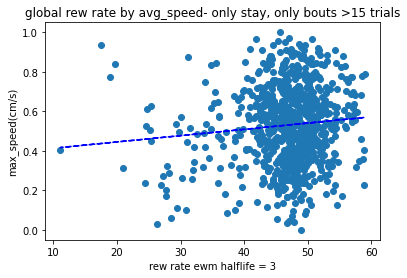

In [279]:
#this only looks at bouts over 15 trials, and their associated avg speed and rew rate 
x=[]
y=[]
for ix in range(len(long_bouts)):
    if long_bouts.iloc[ix].max_speed_per_trial !='NaN':
        if long_bouts.iloc[ix].stem_switch==False:
            x.append(long_bouts.iloc[ix].avg_speed_per_trial)
            y.append(long_bouts.iloc[ix].rew_rate_ewm_epoch)
plt.scatter(x,y)
plt.title('global rew rate by avg_speed- only stay, only bouts >15 trials')
plt.xlabel(f'rew rate ewm halflife = {halflife}')
plt.ylabel('max_speed(cm/s)')


z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"b--")
X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

In [84]:
#this takes only trials above #0, only stay trials, only trials with 1 segemtn switch
#and then geta some amount of time before and after the segment switch, gets the speed, takes avg, and saves it. 
speed_keeper = []
avg_speed=[]
for ix in range(len(trial_times)):
    if trial_times.iloc[ix].trial_number_by_epoch!=0:
        if trial_times.iloc[ix].stem_switch==False: 
            if len(trial_times.iloc[ix].seg_switch_times) ==1: 
                time_at_center = trial_times.iloc[ix].seg_switch_times[0]
                time_start = time_at_center-1
                time_end = time_at_center+1
                epoch= trial_times.iloc[ix].epoch
                for epoch_ix in range(len(epoch_pos)):
                    if epoch_pos[epoch_ix][0]==epoch:
                        pos_num = epoch_pos[epoch_ix][1]
    
    #get the position and linearized position info for that epoch 
                position_info = (IntervalPositionInfo() &
                                 {'nwb_file_name': nwb_file_name,
                                  'interval_list_name': f'pos {pos_num} valid times',
                                  'position_info_param_name': 'default'}
                                ).fetch1_dataframe()
                speed_x,speed_y = get_speed_timestamp(time_start,time_end,position_info)
                speed_keeper.append([speed_y])
            else:
                speed_keeper.append([0])
        else:
            speed_keeper.append([0])
    else:
        speed_keeper.append([0])



In [121]:
trial_times['trial_speeds_1s']=speed_keeper

In [123]:
trial_times

,nwb_file_name,epoch,trial_number_by_epoch,leaf,stem,reward,poke_in_ts,reward_on_ts,reward_off_ts,poke_out_ts,...,trial_len,rew_rate_ewm_leaf,rew_rate_ewm_stem,rew_rate_ewm_epoch,seg_switch_times,avg_speed_per_trial,max_speed_per_trial,min_speed_per_trial,speed_all_trial,trial_speeds_1s
0,senor20201030_.nwb,2,0,4,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,NaN,0.000000,0.000000,0.000000,0,NaN,NaN,NaN,NaN,[0]
1,senor20201030_.nwb,2,1,3,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,2.156,0.000000,0.000000,0.000000,[1604078259.6768906],51.078441,82.84474,14.939608,"[15.062713307249425, 19.321927234376464, 24.02...","[[42.95127214991963, 43.86733681223068, 43.580..."
2,senor20201030_.nwb,2,2,2,A,0,1.604078e+09,NaN,NaN,1.604078e+09,...,4.84,0.000000,0.000000,0.000000,"[1604078268.4768033, 1604078268.810136, 160407...",48.655067,73.394483,2.184796,"[16.376759798195184, 22.196654189333294, 28.52...",[0]
3,senor20201030_.nwb,2,3,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,2.226,1.000000,0.512195,0.268583,[1604078279.2767003],49.832956,71.575427,9.793412,"[9.793411570687521, 13.531200487296626, 18.017...","[[32.57568279012766, 36.10792852734244, 38.296..."
4,senor20201030_.nwb,2,4,2,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,3.727,0.512195,0.682791,0.429477,[1604078292.4099002],33.240799,72.046607,1.453074,"[4.325741268658773, 6.150507068352855, 8.32426...","[[22.56292524021044, 24.788513641690827, 28.07..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,senor20201030_.nwb,14,175,1,A,0,1.604104e+09,NaN,NaN,1.604104e+09,...,2.73,0.484233,0.423502,0.392555,[1604103536.0823658],42.377209,69.27256,3.97578,"[11.78316489530877, 15.58515467318779, 19.1058...","[[31.664944623166665, 28.159526985593736, 25.8..."
1256,senor20201030_.nwb,14,176,2,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,2.67,0.442383,0.452865,0.421487,[1604103539.3156853],42.638762,66.655695,5.594969,"[5.594969397402997, 8.612097514627141, 12.4385...","[[19.276576340031575, 21.62404427356428, 24.83..."
1257,senor20201030_.nwb,14,177,1,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,2.462,0.516675,0.480641,0.449039,[1604103545.7489443],46.99723,68.021411,15.905849,"[15.90584921995597, 20.113960355128164, 24.225...","[[29.21387013494309, 29.84098187186636, 30.496..."
1258,senor20201030_.nwb,14,178,2,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,2.298,0.477458,0.506923,0.475280,[1604103552.8488734],48.893069,68.078626,10.117551,"[10.11755100990477, 13.7862750854686, 18.08672...","[[43.51803373158746, 45.99597855934353, 48.045..."


In [87]:
ix=1

In [112]:
# speed_temp = speed_keeper[ix][0]
type(speed_temp) ==int#==0 #!=0 #is int

True

In [117]:
speed_temp

time
1.604104e+09    21.518272
1.604104e+09    23.724952
1.604104e+09    27.095763
1.604104e+09    31.478390
1.604104e+09    36.661949
                  ...    
1.604104e+09    28.432405
1.604104e+09    23.992151
1.604104e+09    20.115324
1.604104e+09    16.734985
1.604104e+09    13.668763
Name: head_speed, Length: 61, dtype: float64

In [115]:
speed_keeper_all=[]
for ix in range(len(speed_keeper)):
    speed_temp = speed_keeper[ix][0]
    if type(speed_temp)==int:
        speed_keeper_all.append(0)
    else:
        for deeper in range(len(speed_temp)):
            speed_keeper_all.append([speed_temp.iloc[deeper]])

0

In [94]:
#this takes only trials above #0, only stay trials, only trials with 1 segemtn switch
#and then geta some amount of time before and after the segment switch, gets the speed, takes avg, and saves it. 

avg_speed_first=[]
avg_speed_second=[]
# avg_speed_first.append('NaN')
# avg_speed_second.append('NaN')
rew_rate_ewm_epoch_ls=[]
rew_rate_ewm_leaf_ls=[]
rew_rate_ewm_stem_ls=[]

rew_last_trial=[]

max_first=[]
max_second=[]
min_first=[]
min_second =[]

for ix in range(1,len(trial_times)):
    if trial_times.iloc[ix].trial_number_by_epoch!=0:
        if trial_times.iloc[ix].stem_switch==False: 
            if len(trial_times.iloc[ix].seg_switch_times) ==1: 
                time_at_center = trial_times.iloc[ix].seg_switch_times[0]
                time_start = time_at_center-1
                time_end = time_at_center+1
                epoch= trial_times.iloc[ix].epoch
                for epoch_ix in range(len(epoch_pos)):
                    if epoch_pos[epoch_ix][0]==epoch:
                        pos_num = epoch_pos[epoch_ix][1]
    
    #get the position and linearized position info for that epoch 
                position_info = (IntervalPositionInfo() &
                                 {'nwb_file_name': nwb_file_name,
                                  'interval_list_name': f'pos {pos_num} valid times',
                                  'position_info_param_name': 'default'}
                                ).fetch1_dataframe()
                speed_x,speed_y_first = get_speed_timestamp(time_start,time_at_center,position_info)
                speed_x,speed_y_second = get_speed_timestamp(time_at_center,time_end,position_info)

                avg_speed_first.append(statistics.mean(speed_y_first))
                avg_speed_second.append(statistics.mean(speed_y_second))
                
                max_first.append(speed_y_first.max())
                max_second.append(speed_y_second.max())
                min_first.append(speed_y_first.min())
                min_second.append(speed_y_second.min())
                
                rew_rate_ewm_leaf_ls.append(trial_times.iloc[ix].rew_rate_ewm_leaf)
                rew_rate_ewm_stem_ls.append(trial_times.iloc[ix].rew_rate_ewm_stem)
                rew_rate_ewm_epoch_ls.append(trial_times.iloc[ix].rew_rate_ewm_epoch)
                
                rew_last_trial.append(trial_times.iloc[ix-1].reward)




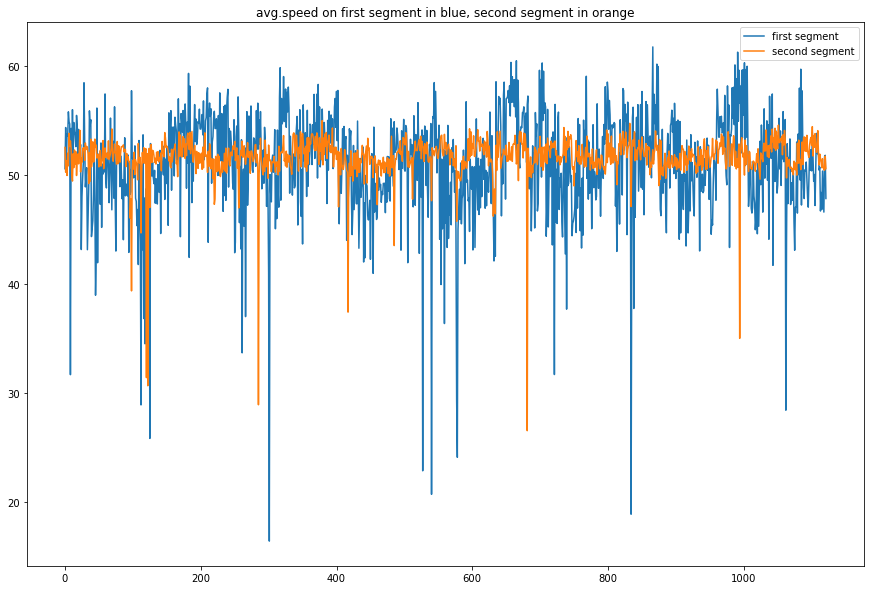

In [59]:
plt.figure(figsize=(15,10))
plt.plot(avg_speed_first,label='first segment')
plt.plot(avg_speed_second,label='second segment')
plt.title('avg speed on first segment in blue, second segment in orange')
plt.legend()


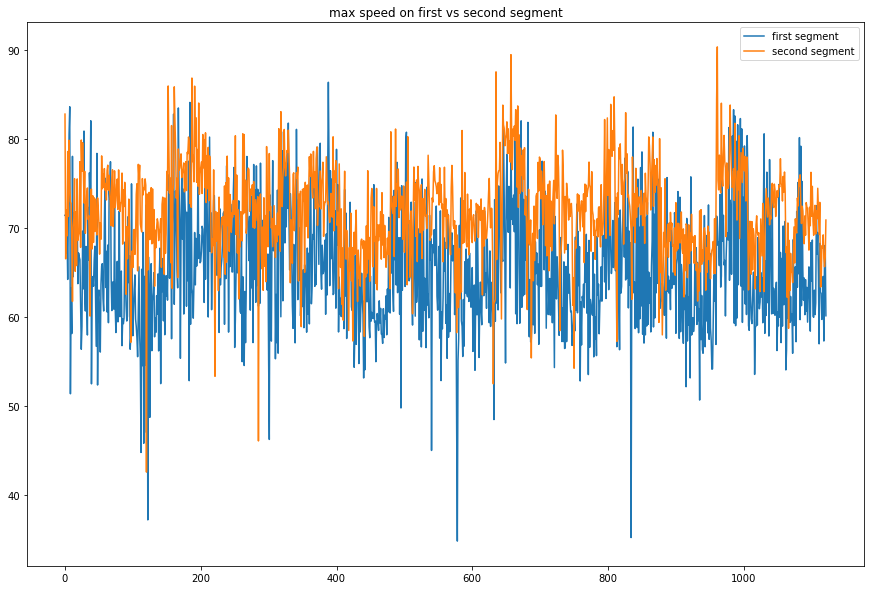

In [62]:
plt.figure(figsize=(15,10))
plt.title('max speed on first vs second segment')
plt.plot(max_first,label='first segment')
plt.plot(max_second,label='second segment')
plt.legend()



Text(0.5, 1.0, 'max speeds per trial across whole day, seperated by segment')

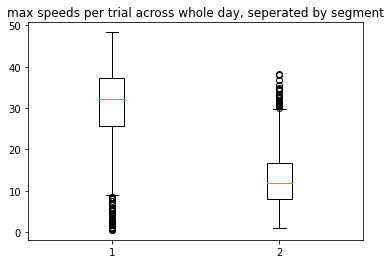

In [83]:
data = [max_first,max_second]
plt.boxplot(data)
# plt.boxplot(avg_speed_second,2)
plt.title('max speeds per trial across whole day, seperated by segment')

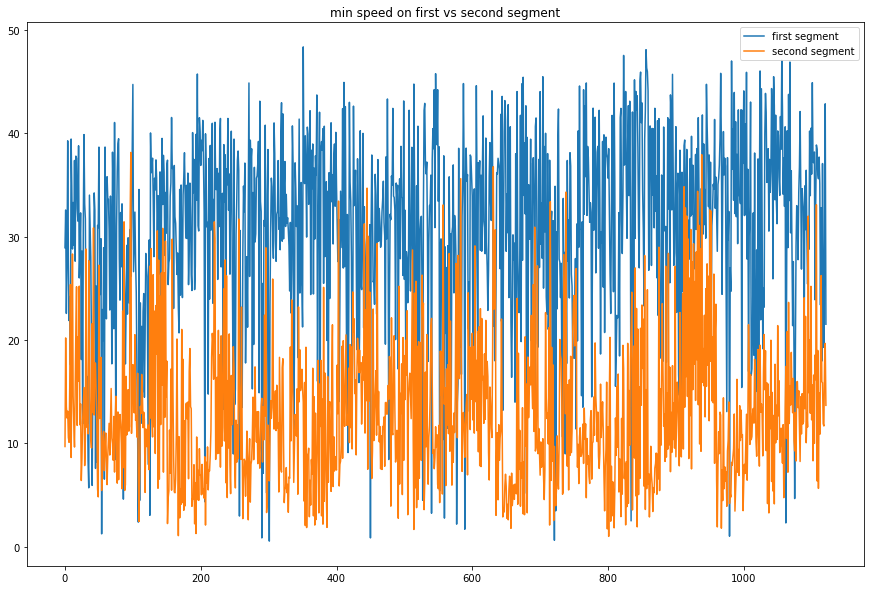

In [63]:
plt.figure(figsize=(15,10))
plt.title('min speed on first vs second segment')
plt.plot(min_first,label='first segment')
plt.plot(min_second,label='second segment')
plt.legend()


In [34]:
len(avg_speed_first)

1123

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     20.53
Date:                Wed, 15 Jun 2022   Prob (F-statistic):           6.51e-06
Time:                        16:27:47   Log-Likelihood:                -3351.6
No. Observations:                1121   AIC:                             6707.
Df Residuals:                    1119   BIC:                             6717.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         49.6300      0.336    147.656      0.0

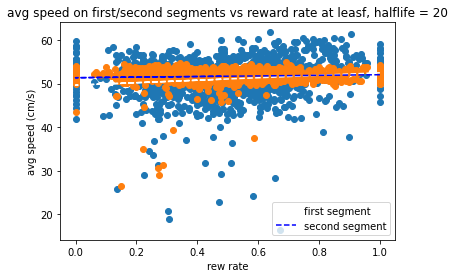

In [92]:
x1=x2 = rew_rate_ewm_leaf_ls[1:]
y1=avg_speed_first[1:]
y2=avg_speed_second[1:]

plt.scatter(x1,y1)
plt.scatter(x2,y2)

z1 = np.polyfit(x1, y1, 1)
p1 = np.poly1d(z1)
plt.plot(x1,p1(x1),"w--",label = 'first segment')
X2 = sm.add_constant(x1)
est = sm.OLS(y1, X2)
est2 = est.fit()
print(est2.summary())

z2 = np.polyfit(x2, y2, 1)
p2 = np.poly1d(z2)
plt.plot(x2,p2(x2),"b--",label = 'second segment')
X2 = sm.add_constant(x2)
est = sm.OLS(y2, X2)
est2 = est.fit()
print(est2.summary())

plt.title(f'avg speed on first/second segments vs reward rate at leasf, halflife = {halflife}')
plt.xlabel('rew rate')
plt.ylabel('avg speed (cm/s)')
plt.legend()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     25.19
Date:                Wed, 15 Jun 2022   Prob (F-statistic):           6.03e-07
Time:                        16:39:43   Log-Likelihood:                -3727.0
No. Observations:                1121   AIC:                             7458.
Df Residuals:                    1119   BIC:                             7468.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         63.1828      0.470    134.477      0.0

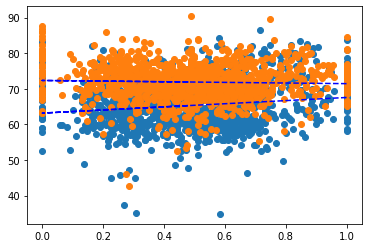

In [96]:
x1=x2 = rew_rate_ewm_leaf_ls[1:]
y1=max_first[1:]
y2=max_second[1:]

plt.scatter(x1,y1)
plt.scatter(x2,y2)

z1 = np.polyfit(x1, y1, 1)
p1 = np.poly1d(z1)
plt.plot(x1,p1(x1),"b--")
X2 = sm.add_constant(x1)
est = sm.OLS(y1, X2)
est2 = est.fit()
print(est2.summary())

z2 = np.polyfit(x2, y2, 1)
p2 = np.poly1d(z2)
plt.plot(x2,p2(x2),"b--")
X2 = sm.add_constant(x2)
est = sm.OLS(y2, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.06080
Date:                Wed, 15 Jun 2022   Prob (F-statistic):              0.805
Time:                        16:39:34   Log-Likelihood:                -4080.8
No. Observations:                1121   AIC:                             8166.
Df Residuals:                    1119   BIC:                             8176.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.8148      0.644     47.838      0.0

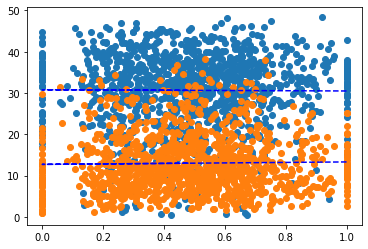

In [95]:
x1=x2 = rew_rate_ewm_leaf_ls[1:]
y1=min_first[1:]
y2=min_second[1:]

plt.scatter(x1,y1)
plt.scatter(x2,y2)

z1 = np.polyfit(x1, y1, 1)
p1 = np.poly1d(z1)
plt.plot(x1,p1(x1),"b--")
X2 = sm.add_constant(x1)
est = sm.OLS(y1, X2)
est2 = est.fit()
print(est2.summary())

z2 = np.polyfit(x2, y2, 1)
p2 = np.poly1d(z2)
plt.plot(x2,p2(x2),"b--")
X2 = sm.add_constant(x2)
est = sm.OLS(y2, X2)
est2 = est.fit()
print(est2.summary())

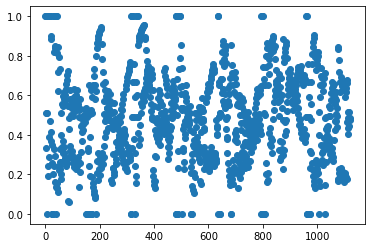

In [99]:
x1=x2 = rew_rate_ewm_leaf_ls[1:]
plt.scatter(range(len(x1)),x1)

In [14]:
avg_speed_after_rew_first=[]
avg_speed_after_rew_second=[]
avg_speed_after_no_rew_first=[]
avg_speed_after_no_rew_second=[]
for ix in range(len(rew_last_trial)):
    if rew_last_trial[ix]==1:
        avg_speed_after_rew_first.append(max_first[ix])
        avg_speed_after_rew_second.append(max_second[ix])
    else:
        avg_speed_after_no_rew_first.append(max_first[ix])
        avg_speed_after_no_rew_second.append(max_second[ix])





NameError: name 'rew_last_trial' is not defined

In [ ]:
plt

Text(0.5, 1.0, 'max speed, first seg (0,1)=(rew, no rew), (2,3)=second seg(rew, no rew)')

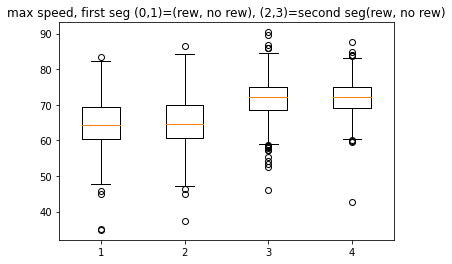

In [108]:
data = [avg_speed_after_rew_first,avg_speed_after_no_rew_first,avg_speed_after_rew_second,avg_speed_after_no_rew_second]
plt.boxplot(data)
plt.title(f'max speed, first seg (0,1)=(rew, no rew), (2,3)=second seg(rew, no rew)')


In [110]:
#last ditch effort, epoch. 

#this takes only trials above #0, only stay trials, only trials with 1 segemtn switch
#and then geta some amount of time before and after the segment switch, gets the speed, takes avg, and saves it. 

avg_speed_first=[]
avg_speed_second=[]
# avg_speed_first.append('NaN')
# avg_speed_second.append('NaN')
rew_rate_ewm_epoch_ls=[]
rew_rate_ewm_leaf_ls=[]
rew_rate_ewm_stem_ls=[]

rew_last_trial=[]

max_first=[]
max_second=[]
min_first=[]
min_second =[]

for ix in range(1,len(trial_times)):
    if trial_times.iloc[ix].trial_number_by_epoch!=0:
        if trial_times.iloc[ix].epoch==2:
            if trial_times.iloc[ix].stem_switch==False: 
                if len(trial_times.iloc[ix].seg_switch_times) ==1: 
                    time_at_center = trial_times.iloc[ix].seg_switch_times[0]
                    time_start = time_at_center-1
                    time_end = time_at_center+1
                    epoch= trial_times.iloc[ix].epoch
                    # for epoch_ix in range(len(epoch_pos)):
                    #     if epoch_pos[epoch_ix][0]==epoch:
                    #         pos_num = epoch_pos[epoch_ix][1]

        #get the position and linearized position info for that epoch 
                    position_info = (IntervalPositionInfo() &
                                     {'nwb_file_name': nwb_file_name,
                                      'interval_list_name': f'pos 1 valid times',
                                      'position_info_param_name': 'default'}
                                    ).fetch1_dataframe()
                    speed_x,speed_y_first = get_speed_timestamp(time_start,time_at_center,position_info)
                    speed_x,speed_y_second = get_speed_timestamp(time_at_center,time_end,position_info)

                    avg_speed_first.append(statistics.mean(speed_y_first))
                    avg_speed_second.append(statistics.mean(speed_y_second))

                    max_first.append(speed_y_first.max())
                    max_second.append(speed_y_second.max())
                    min_first.append(speed_y_first.min())
                    min_second.append(speed_y_second.min())

                    rew_rate_ewm_leaf_ls.append(trial_times.iloc[ix].rew_rate_ewm_leaf)
                    rew_rate_ewm_stem_ls.append(trial_times.iloc[ix].rew_rate_ewm_stem)
                    rew_rate_ewm_epoch_ls.append(trial_times.iloc[ix].rew_rate_ewm_epoch)

                    rew_last_trial.append(trial_times.iloc[ix-1].reward)




In [ ]:
plt.scatter(avg_speed_first,

In [97]:
statistics.mean(avg_speed_first[1:])

51.006383017739914

In [98]:
statistics.mean(avg_speed_second[1:])

51.672831163900376

In [281]:
len(avg_speed)

1122

In [282]:
#tihis is to go throug hthe same for loops from above, but only save the associated rew rate 
rew_rate=[]
for ix in range(len(trial_times)):
    if trial_times.iloc[ix].trial_number_by_epoch!=0:
        if trial_times.iloc[ix].stem_switch==False: 
            if len(trial_times.iloc[ix].seg_switch_times) ==1:
                rew_rate.append(trial_times.iloc[ix].rew_rate_ewm_epoch)

In [283]:
len(rew_rate)

1122

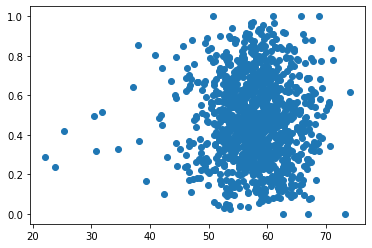

In [284]:
plt.scatter(avg_speed,rew_rate)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     8.229
Date:                Mon, 06 Jun 2022   Prob (F-statistic):            0.00462
Time:                        16:27:58   Log-Likelihood:                -607.78
No. Observations:                 179   AIC:                             1220.
Df Residuals:                     177   BIC:                             1226.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         40.3374      1.249     32.286      0.0

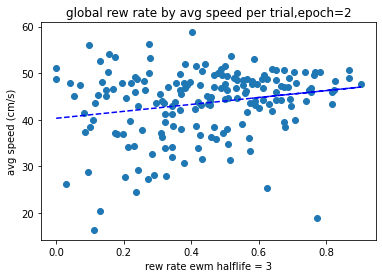

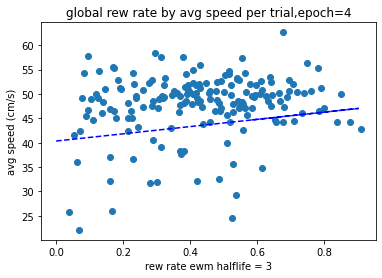

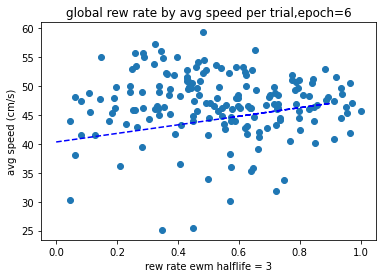

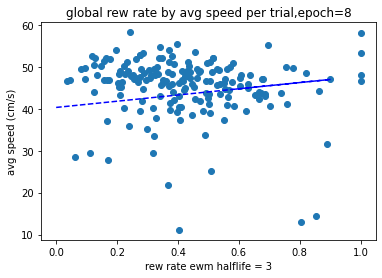

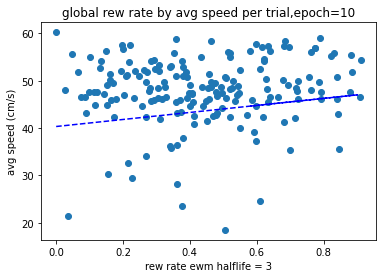

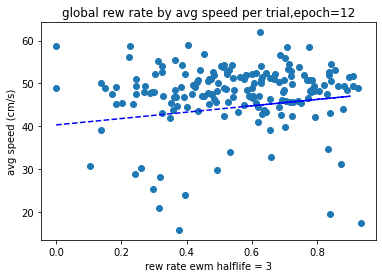

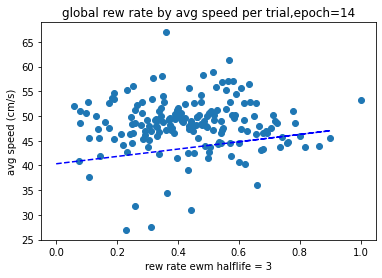

In [285]:
#plot x epochs individually, min, max, avg speed. just have to hcange the word 
for ix in range(2,16,2):
    
    epoch_df = trial_times[trial_times.epoch==ix]
    
    
    plt.figure()
    plt.scatter(epoch_df.rew_rate_ewm_epoch[1:],epoch_df.avg_speed_per_trial[1:])
    plt.title(f'global rew rate by avg speed per trial,epoch={ix}')
    plt.xlabel(f'rew rate ewm halflife = {halflife}')
    plt.ylabel('avg speed (cm/s)')



    x=(e2.rew_rate_ewm_epoch[1:]).tolist()
    y=(e2.avg_speed_per_trial[1:]).tolist()
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x,p(x),"b--")
    X2 = sm.add_constant(x)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    print(est2.summary())

Text(0, 0.5, 'speed ( cm/s)')

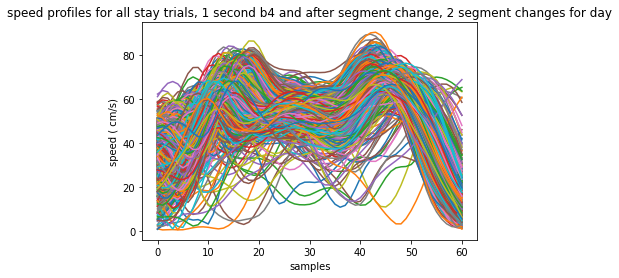

In [286]:
# plot speeds across trials from above to make sure they dont in;cude much immobility 

avg_speed=[]
for ix in range(int(len(trial_times))):
    if trial_times.iloc[ix].trial_number_by_epoch!=0:
        if trial_times.iloc[ix].stem_switch==False: 
            if len(trial_times.iloc[ix].seg_switch_times) ==1: 
                time_at_center = trial_times.iloc[ix].seg_switch_times[0]
                time_start = time_at_center-1
                time_end = time_at_center+1
                epoch= trial_times.iloc[ix].epoch
                for epoch_ix in range(len(epoch_pos)):
                    if epoch_pos[epoch_ix][0]==epoch:
                        pos_num = epoch_pos[epoch_ix][1]
    
    #get the position and linearized position info for that epoch 
                position_info = (IntervalPositionInfo() &
                                 {'nwb_file_name': nwb_file_name,
                                  'interval_list_name': f'pos {pos_num} valid times',
                                  'position_info_param_name': 'default'}
                                ).fetch1_dataframe()
                speed_x,speed_y = get_speed_timestamp(time_start,time_end,position_info)
                plt.plot(range(len(speed_x)),speed_y)
plt.title('speed profiles for all stay trials, 1 second b4 and after segment change, 2 segment changes for day')
plt.xlabel('samples')
plt.ylabel('speed ( cm/s)')

In [287]:
#want to ask if he runs faster after rew or no reward 
e2

,nwb_file_name,epoch,trial_number_by_epoch,leaf,stem,reward,poke_in_ts,reward_on_ts,reward_off_ts,poke_out_ts,...,trial_len,rew_rate_ewm_leaf,rew_rate_ewm_stem,rew_rate_ewm_epoch,avg_speed_per_trial,max_speed_per_trial,min_speed_per_trial,bout_num,bout_lens_per_bout,seg_switch_times
0,senor20201030_.nwb,2,0,4,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,1,2.0,0
1,senor20201030_.nwb,2,1,3,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,2.156,0.000000,0.000000,0.000000,51.078441,82.84474,14.939608,1,2.0,[1604078259.6768906]
2,senor20201030_.nwb,2,2,2,A,0,1.604078e+09,NaN,NaN,1.604078e+09,...,4.84,0.000000,0.000000,0.000000,48.655067,73.394483,2.184796,2,6.0,"[1604078268.4768033, 1604078268.810136, 160407..."
3,senor20201030_.nwb,2,3,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,2.226,1.000000,0.571429,0.365714,49.832956,71.575427,9.793412,2,6.0,[1604078279.2767003]
4,senor20201030_.nwb,2,4,2,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,3.727,0.571429,0.756757,0.573624,33.240799,72.046607,1.453074,2,6.0,[1604078292.4099002]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,senor20201030_.nwb,2,175,6,C,0,1.604079e+09,NaN,NaN,1.604079e+09,...,3.237,0.488473,0.459422,0.459531,36.396941,73.42174,0.832136,16,30.0,[1604079361.7658658]
176,senor20201030_.nwb,2,176,5,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,2.484,0.689370,0.594567,0.594648,47.783901,67.189868,12.573764,16,30.0,[1604079364.9991605]
177,senor20201030_.nwb,2,177,6,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,2.679,0.616427,0.695925,0.695986,42.932353,69.433113,2.320955,16,30.0,[1604079372.9324226]
178,senor20201030_.nwb,2,178,5,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,6.646,0.767052,0.771944,0.771990,18.862685,76.406325,0.031708,16,30.0,[1604079385.2989662]


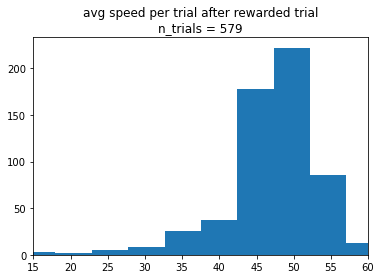

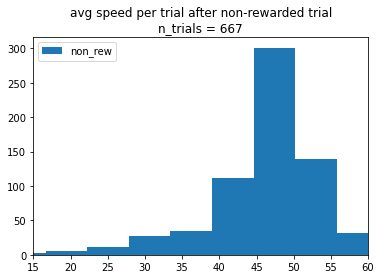

In [288]:
rewarded_avg_speed=[]
non_rew_avg_speed=[]
for ix in range(1,len(trial_times)):
    if trial_times.iloc[ix-1].trial_number_by_epoch!=0:
        if trial_times.iloc[ix].trial_number_by_epoch!=0:
            if trial_times.iloc[ix-1].reward ==1:
                rewarded_avg_speed.append(trial_times.iloc[ix].avg_speed_per_trial)
            # if trial_times.iloc[ix-1].trial_number_by_epoch!=0:


            elif trial_times.iloc[ix-1].reward==0: 
                non_rew_avg_speed.append(trial_times.iloc[ix].avg_speed_per_trial)

# plt.figure(figsize=(15,10))        
plt.hist(rewarded_avg_speed,label='rewarded')
plt.xlim(15,60)
plt.title(f'avg speed per trial after rewarded trial\nn_trials = {len(rewarded_avg_speed)}')
plt.figure()
plt.xlim(15,60)
plt.hist(non_rew_avg_speed,label='non_rew')
plt.title(f'avg speed per trial after non-rewarded trial\nn_trials = {len(non_rew_avg_speed)}')


plt.legend()

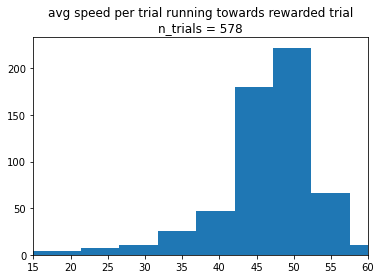

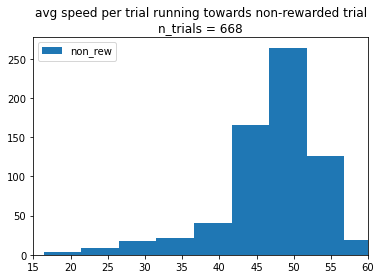

In [289]:
rewarded_avg_speed=[]
non_rew_avg_speed=[]
for ix in range(1,len(trial_times)):
    if trial_times.iloc[ix-1].trial_number_by_epoch!=0:
        if trial_times.iloc[ix].trial_number_by_epoch!=0:
            if trial_times.iloc[ix].reward ==1:
                rewarded_avg_speed.append(trial_times.iloc[ix].avg_speed_per_trial)
            # if trial_times.iloc[ix-1].trial_number_by_epoch!=0:


            elif trial_times.iloc[ix].reward==0: 
                non_rew_avg_speed.append(trial_times.iloc[ix].avg_speed_per_trial)

# plt.figure(figsize=(15,10))        
plt.hist(rewarded_avg_speed,label='rewarded')
plt.xlim(15,60)
plt.title(f'avg speed per trial running towards rewarded trial\nn_trials = {len(rewarded_avg_speed)}')
plt.figure()
plt.xlim(15,60)
plt.hist(non_rew_avg_speed,label='non_rew')
plt.title(f'avg speed per trial running towards non-rewarded trial\nn_trials = {len(non_rew_avg_speed)}')


plt.legend()

In [290]:
mean_rew = statistics.mean(rewarded_avg_speed)
mean_non_rew = statistics.mean(non_rew_avg_speed)
print(mean_rew,mean_non_rew)

46.24074835064531 47.04575170585941


In [ ]:
non_rew_avg_speed

In [358]:
long_bouts = e2[e2.bout_lens_per_bout>15]

In [359]:
long_bouts[long_bouts.avg_speed_per_trial=='NaN']

,nwb_file_name,epoch,trial_number_by_epoch,leaf,stem,reward,poke_in_ts,reward_on_ts,reward_off_ts,poke_out_ts,...,trial_len,rew_rate_ewm_leaf,rew_rate_ewm_stem,rew_rate_ewm_epoch,avg_speed_per_trial,max_speed_per_trial,min_speed_per_trial,bout_num,bout_lens_per_bout,seg_switch_times


In [301]:
#at some point should do a groupby cunsum on long bouts to only look at speeds in latter half of the long bout 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     3.608
Date:                Tue, 07 Jun 2022   Prob (F-statistic):             0.0599
Time:                        11:35:53   Log-Likelihood:                -401.70
No. Observations:                 121   AIC:                             807.4
Df Residuals:                     119   BIC:                             813.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.6434      1.353     30.779      0.0

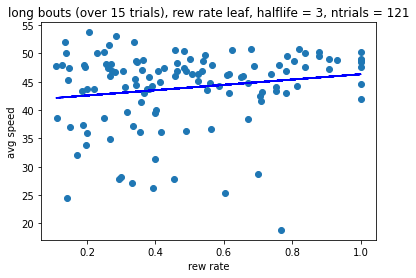

In [362]:
x=[]
y=[]
for ix in range(len(long_bouts)):
    if long_bouts.iloc[ix].trial_number_by_epoch !=0:
        x.append(long_bouts.iloc[ix].rew_rate_ewm_leaf)
        y.append(long_bouts.iloc[ix].avg_speed_per_trial)
plt.scatter(x,y)
plt.title(f'long bouts (over 15 trials), rew rate leaf, halflife = {halflife}, ntrials = {len(x)}')
plt.xlabel('rew rate')
plt.ylabel('avg speed')

# x=(long_bouts.avg_speed_per_trial).tolist()
# y=(long_bouts.rew_rate_ewm_leaf).tolist()
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"b--")
X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

In [361]:
long_bouts

,nwb_file_name,epoch,trial_number_by_epoch,leaf,stem,reward,poke_in_ts,reward_on_ts,reward_off_ts,poke_out_ts,...,trial_len,rew_rate_ewm_leaf,rew_rate_ewm_stem,rew_rate_ewm_epoch,avg_speed_per_trial,max_speed_per_trial,min_speed_per_trial,bout_num,bout_lens_per_bout,seg_switch_times
13,senor20201030_.nwb,2,13,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,5.342,1.000000,0.786363,0.692842,44.550004,80.073429,1.292436,5,17.0,"[1604078368.5758092, 1604078368.6091342, 16040..."
14,senor20201030_.nwb,2,14,2,A,0,1.604078e+09,NaN,NaN,1.604078e+09,...,2.025,0.205714,0.567902,0.517286,53.736003,72.813825,9.744549,5,17.0,[1604078380.1756775]
15,senor20201030_.nwb,2,15,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,2.798,1.000000,0.684696,0.639186,41.895874,68.699196,8.248265,5,17.0,[1604078383.7423227]
16,senor20201030_.nwb,2,16,2,A,0,1.604078e+09,NaN,NaN,1.604078e+09,...,2.186,0.138284,0.503307,0.478179,50.007276,78.098212,9.516181,5,17.0,[1604078392.0755634]
17,senor20201030_.nwb,2,17,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,2.296,1.000000,0.632956,0.609374,48.844173,70.114234,8.651648,5,17.0,[1604078395.0088663]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,senor20201030_.nwb,2,175,6,C,0,1.604079e+09,NaN,NaN,1.604079e+09,...,3.237,0.488473,0.459422,0.459531,36.396941,73.42174,0.832136,16,30.0,[1604079361.7658658]
176,senor20201030_.nwb,2,176,5,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,2.484,0.689370,0.594567,0.594648,47.783901,67.189868,12.573764,16,30.0,[1604079364.9991605]
177,senor20201030_.nwb,2,177,6,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,2.679,0.616427,0.695925,0.695986,42.932353,69.433113,2.320955,16,30.0,[1604079372.9324226]
178,senor20201030_.nwb,2,178,5,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,6.646,0.767052,0.771944,0.771990,18.862685,76.406325,0.031708,16,30.0,[1604079385.2989662]


In [303]:
#should try to get back to working with whole distributions instead of just average speed. 




In [304]:
#also want to look at speeds speeds across segments 

In [308]:
speed_first_seg=[]
speed_second_seg=[]
speed_keeper_first=[]
speed_keeper_second=[]



for ix in range(int(len(trial_times))):
    if trial_times.iloc[ix].trial_number_by_epoch!=0:
        if trial_times.iloc[ix].stem_switch==False: 
            if len(trial_times.iloc[ix].seg_switch_times) ==1: 
                time_at_center = trial_times.iloc[ix].seg_switch_times[0]
                time_start = time_at_center-1
                time_end = time_at_center+1
                epoch= trial_times.iloc[ix].epoch
                for epoch_ix in range(len(epoch_pos)):
                    if epoch_pos[epoch_ix][0]==epoch:
                        pos_num = epoch_pos[epoch_ix][1]
    
    #get the position and linearized position info for that epoch 
                position_info = (IntervalPositionInfo() &
                                 {'nwb_file_name': nwb_file_name,
                                  'interval_list_name': f'pos {pos_num} valid times',
                                  'position_info_param_name': 'default'}
                                ).fetch1_dataframe()
                speed_x,speed_y = get_speed_timestamp(time_start,time_at_center,position_info)
                speed_first_seg.append(speed_y)

                speed_x,speed_y = get_speed_timestamp(time_at_center,time_end,position_info)
                speed_second_seg.append(speed_y)               

                

In [328]:
speed_keeper_first=[]
for ix in range(len(speed_first_seg)):
    speed_temp = speed_first_seg[ix]
    for deeper in range(len(speed_temp)):
        speed_keeper_first.append(speed_temp.iloc[deeper])

In [326]:
speed_keeper_second=[]
for ix in range(len(speed_second_seg)):
    speed_temp = speed_second_seg[ix]
    for deeper in range(len(speed_temp)):
        speed_keeper_second.append(speed_temp.iloc[deeper])

mean first segment speeds = 51.005871836822
mean second segment speeds = 51.67099588679478


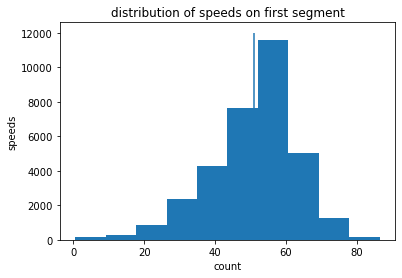

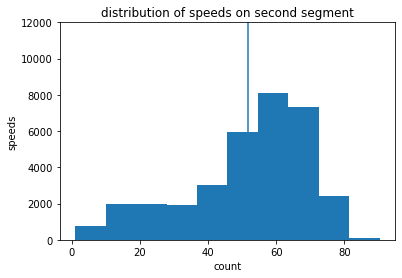

In [333]:
plt.hist(speed_keeper_first)
plt.title('distribution of speeds on first segment')
plt.xlabel('count')
plt.ylabel('speeds')
plt.vlines(statistics.mean(speed_keeper_first),0,12000)
print(f'mean first segment speeds = {statistics.mean(speed_keeper_first)}')

plt.figure()
plt.hist(speed_keeper_second)
plt.title('distribution of speeds on second segment')
plt.xlabel('count')
plt.ylabel('speeds')
plt.ylim(0,12000)
plt.vlines(statistics.mean(speed_keeper_second),0,12000)
print(f'mean second segment speeds = {statistics.mean(speed_keeper_second)}')




In [334]:
#ask if he runs faster if he just recieved reward

In [336]:
avg_speed_after_reward=[]
avg_speed_after_no_reward=[]
for ix in range(1,len(e2)):
    if e2.iloc[ix-1].reward==1:
        avg_speed_after_reward.append(e2.iloc[ix].avg_speed_per_trial)
    else:
        avg_speed_after_no_reward.append(e2.iloc[ix].avg_speed_per_trial)

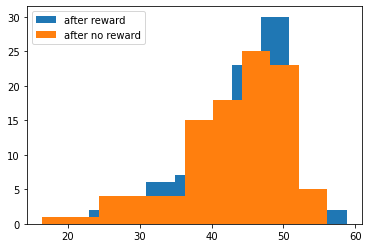

In [337]:
#already did this ugh
plt.hist(avg_speed_after_reward,label='after reward')
plt.hist(avg_speed_after_no_reward,label='after no reward')
plt.legend()

In [339]:
avg_speed_towards_large=[]
avg_speed_towards_small=[]
for ix in range(1,len(e2)):
    if e2.iloc[ix].rew_rate_ewm_leaf>=.5:
        avg_speed_towards_large.append(e2.iloc[ix].avg_speed_per_trial)
    else:
        avg_speed_towards_small.append(e2.iloc[ix].avg_speed_per_trial)

(15.0, 60.0)

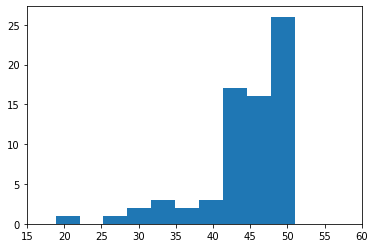

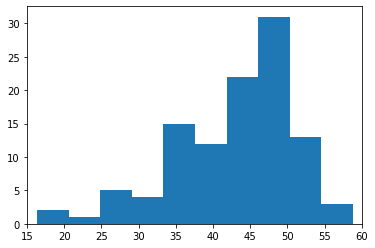

In [342]:
plt.title('avg speed towards stem if rew rate leaf >.5')
plt.hist(avg_speed_towards_large)
plt.xlim(15,60)
plt.figure()
plt.title('avg speed towards stem if rew rate leaf >.5')


plt.hist(avg_speed_towards_small)
plt.xlim(15,60)



In [338]:
e2.iloc[ix].rew_rate_ewm_leaf

0.46225504037633647

In [368]:
speed_rewarded_trials=[]
speed_nonrewarded_trials=[]
for ix in range(int(len(trial_times))):
    if trial_times.iloc[ix].trial_number_by_epoch!=0:
        if trial_times.iloc[ix].stem_switch==False: 
            if len(trial_times.iloc[ix].seg_switch_times) ==1:
                if trial_times.iloc[ix-1].reward ==1:
                    time_at_center = trial_times.iloc[ix].seg_switch_times[0]
                    time_start = time_at_center-1
                    time_end = time_at_center+1
                    epoch= trial_times.iloc[ix].epoch
                    for epoch_ix in range(len(epoch_pos)):
                        if epoch_pos[epoch_ix][0]==epoch:
                            pos_num = epoch_pos[epoch_ix][1]

        #get the position and linearized position info for that epoch 
                    position_info = (IntervalPositionInfo() &
                                     {'nwb_file_name': nwb_file_name,
                                      'interval_list_name': f'pos {pos_num} valid times',
                                      'position_info_param_name': 'default'}
                                    ).fetch1_dataframe()
                    speed_x,speed_y = get_speed_timestamp(time_start,time_end,position_info)
                    speed_rewarded_trials.append(speed_y) 

for ix in range(int(len(trial_times))):
    if trial_times.iloc[ix].trial_number_by_epoch!=0:
        if trial_times.iloc[ix].stem_switch==False: 
            if len(trial_times.iloc[ix].seg_switch_times) ==1:
                if trial_times.iloc[ix-1].reward ==0:
                    time_at_center = trial_times.iloc[ix].seg_switch_times[0]
                    time_start = time_at_center-1
                    time_end = time_at_center+1
                    epoch= trial_times.iloc[ix].epoch
                    for epoch_ix in range(len(epoch_pos)):
                        if epoch_pos[epoch_ix][0]==epoch:
                            pos_num = epoch_pos[epoch_ix][1]

        #get the position and linearized position info for that epoch 
                    position_info = (IntervalPositionInfo() &
                                     {'nwb_file_name': nwb_file_name,
                                      'interval_list_name': f'pos {pos_num} valid times',
                                      'position_info_param_name': 'default'}
                                    ).fetch1_dataframe()
                    speed_x,speed_y = get_speed_timestamp(time_start,time_end,position_info)
                    speed_nonrewarded_trials.append(speed_y)                     


In [369]:
speed_keeper_rew=[]
for ix in range(len(speed_rewarded_trials)):
    speed_temp = speed_rewarded_trials[ix]
    for deeper in range(len(speed_temp)):
        speed_keeper_rew.append(speed_temp.iloc[deeper])

In [370]:
speed_keeper_nonrew=[]
for ix in range(len(speed_nonrewarded_trials)):
    speed_temp = speed_nonrewarded_trials[ix]
    for deeper in range(len(speed_temp)):
        speed_keeper_nonrew.append(speed_temp.iloc[deeper])

Text(0, 0.5, 'count')

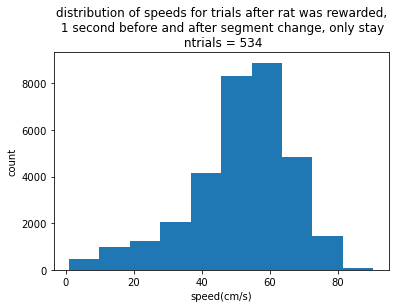

In [374]:
plt.hist(speed_keeper_rew)
plt.title(f'distribution of speeds for trials after rat was rewarded,\n 1 second before and after segment change, only stay\n ntrials = {len(speed_rewarded_trials)}')
plt.xlabel('speed(cm/s)')
plt.ylabel('count')

Text(0, 0.5, 'count')

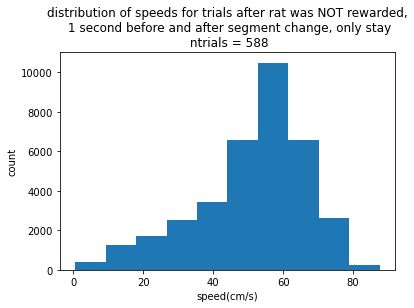

In [376]:
plt.hist(speed_keeper_nonrew)
plt.title(f'distribution of speeds for trials after rat was NOT rewarded,\n 1 second before and after segment change, only stay\n ntrials = {len(speed_nonrewarded_trials)}')
plt.xlabel('speed(cm/s)')
plt.ylabel('count')

In [378]:
print(f'median non rewarded = {statistics.median(speed_keeper_nonrew)}')
print(f'median rewarded = {statistics.median(speed_keeper_rew)}')

median non rewarded = 54.43586484901429
median rewarded = 53.72602738212164


In [379]:
trial_times

,nwb_file_name,epoch,trial_number_by_epoch,leaf,stem,reward,poke_in_ts,reward_on_ts,reward_off_ts,poke_out_ts,...,trial_len,rew_rate_ewm_leaf,rew_rate_ewm_stem,rew_rate_ewm_epoch,avg_speed_per_trial,max_speed_per_trial,min_speed_per_trial,bout_num,bout_lens_per_bout,seg_switch_times
0,senor20201030_.nwb,2,0,4,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,1,2.0,0
1,senor20201030_.nwb,2,1,3,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,2.156,0.000000,0.000000,0.000000,51.078441,82.84474,14.939608,1,2.0,[1604078259.6768906]
2,senor20201030_.nwb,2,2,2,A,0,1.604078e+09,NaN,NaN,1.604078e+09,...,4.84,0.000000,0.000000,0.000000,48.655067,73.394483,2.184796,2,6.0,"[1604078268.4768033, 1604078268.810136, 160407..."
3,senor20201030_.nwb,2,3,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,2.226,1.000000,0.571429,0.365714,49.832956,71.575427,9.793412,2,6.0,[1604078279.2767003]
4,senor20201030_.nwb,2,4,2,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,3.727,0.571429,0.756757,0.573624,33.240799,72.046607,1.453074,2,6.0,[1604078292.4099002]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,senor20201030_.nwb,14,175,1,A,0,1.604104e+09,NaN,NaN,1.604104e+09,...,2.73,0.538468,0.283583,0.337306,42.377209,69.27256,3.97578,92,11.0,[1604103536.0823658]
1256,senor20201030_.nwb,14,176,2,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,2.67,0.334064,0.462688,0.502979,42.638762,66.655695,5.594969,92,11.0,[1604103539.3156853]
1257,senor20201030_.nwb,14,177,1,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,2.462,0.653879,0.597016,0.627234,46.99723,68.021411,15.905849,92,11.0,[1604103545.7489443]
1258,senor20201030_.nwb,14,178,2,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,2.298,0.500588,0.697762,0.720426,48.893069,68.078626,10.117551,92,11.0,[1604103552.8488734]


In [380]:
speed_towards_high=[]
speed_towards_low=[]
for ix in range(int(len(trial_times))):
    if trial_times.iloc[ix].trial_number_by_epoch!=0:
        if trial_times.iloc[ix].stem_switch==False: 
            if len(trial_times.iloc[ix].seg_switch_times) ==1:
                if trial_times.iloc[ix].rew_rate_ewm_leaf >.5:
                    time_at_center = trial_times.iloc[ix].seg_switch_times[0]
                    time_start = time_at_center-1
                    time_end = time_at_center+1
                    epoch= trial_times.iloc[ix].epoch
                    for epoch_ix in range(len(epoch_pos)):
                        if epoch_pos[epoch_ix][0]==epoch:
                            pos_num = epoch_pos[epoch_ix][1]

        #get the position and linearized position info for that epoch 
                    position_info = (IntervalPositionInfo() &
                                     {'nwb_file_name': nwb_file_name,
                                      'interval_list_name': f'pos {pos_num} valid times',
                                      'position_info_param_name': 'default'}
                                    ).fetch1_dataframe()
                    speed_x,speed_y = get_speed_timestamp(time_start,time_end,position_info)
                    speed_towards_high.append(speed_y) 

for ix in range(int(len(trial_times))):
    if trial_times.iloc[ix].trial_number_by_epoch!=0:
        if trial_times.iloc[ix].stem_switch==False: 
            if len(trial_times.iloc[ix].seg_switch_times) ==1:
                if trial_times.iloc[ix].rew_rate_ewm_leaf <=.5:
                    time_at_center = trial_times.iloc[ix].seg_switch_times[0]
                    time_start = time_at_center-1
                    time_end = time_at_center+1
                    epoch= trial_times.iloc[ix].epoch
                    for epoch_ix in range(len(epoch_pos)):
                        if epoch_pos[epoch_ix][0]==epoch:
                            pos_num = epoch_pos[epoch_ix][1]

        #get the position and linearized position info for that epoch 
                    position_info = (IntervalPositionInfo() &
                                     {'nwb_file_name': nwb_file_name,
                                      'interval_list_name': f'pos {pos_num} valid times',
                                      'position_info_param_name': 'default'}
                                    ).fetch1_dataframe()
                    speed_x,speed_y = get_speed_timestamp(time_start,time_end,position_info)
                    speed_towards_low.append(speed_y)                     



In [381]:
speed_keeper_high=[]
for ix in range(len(speed_towards_high)):
    speed_temp = speed_towards_high[ix]
    for deeper in range(len(speed_temp)):
        speed_keeper_high.append(speed_temp.iloc[deeper])

speed_keeper_low=[]
for ix in range(len(speed_towards_low)):
    speed_temp = speed_towards_low[ix]
    for deeper in range(len(speed_temp)):
        speed_keeper_low.append(speed_temp.iloc[deeper])

Text(0, 0.5, 'count')

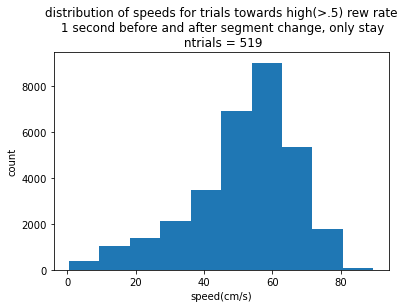

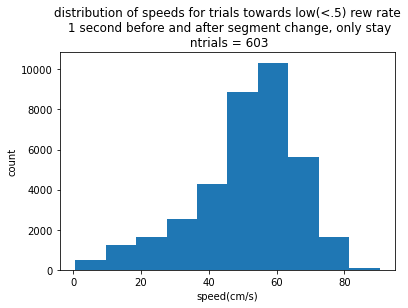

In [391]:
plt.hist(speed_keeper_high)
plt.title(f'distribution of speeds for trials towards high(>.5) rew rate\n 1 second before and after segment change, only stay\n ntrials = {len(speed_towards_high)}')
plt.xlabel('speed(cm/s)')
plt.ylabel('count')
plt.figure()
plt.hist(speed_keeper_low)
plt.title(f'distribution of speeds for trials towards low(<.5) rew rate\n 1 second before and after segment change, only stay\n ntrials = {len(speed_towards_low)}')
plt.xlabel('speed(cm/s)')
plt.ylabel('count')

In [392]:
print(f'mean high = {statistics.mean(speed_keeper_high)}')
print(f'mean low = {statistics.mean(speed_keeper_low)}')

mean high = 51.51566718746506
mean low = 51.257429833201556


Text(0.5, 0, 'rew rate ewm leaf window =3')

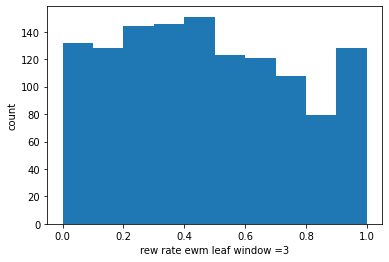

In [384]:
plt.hist(trial_times.rew_rate_ewm_leaf)
plt.ylabel('count')
plt.xlabel(f'rew rate ewm leaf window ={halflife}')

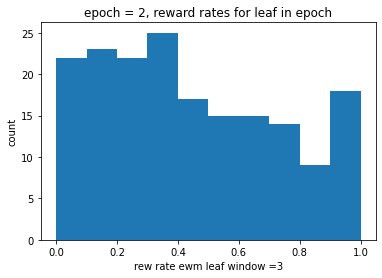

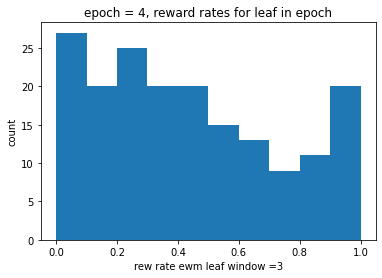

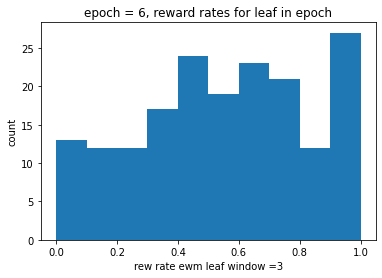

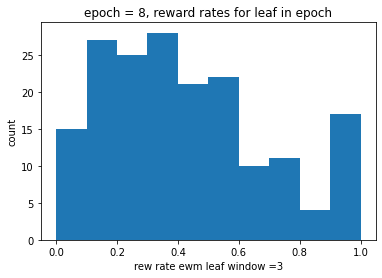

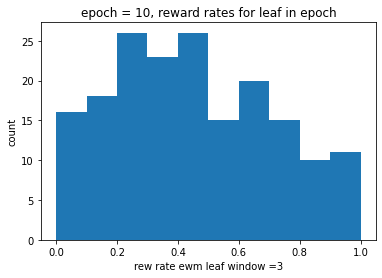

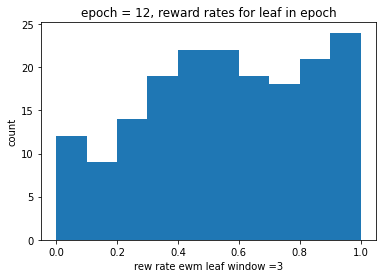

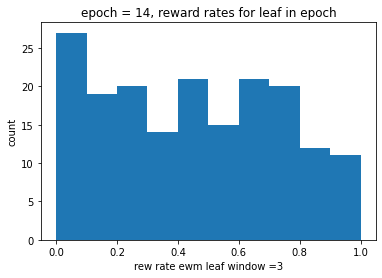

In [393]:
for ix in range(2,trial_times.epoch.max()+2,2):
    epoch_df = trial_times[trial_times.epoch==ix]
    plt.figure()
    plt.hist(epoch_df.rew_rate_ewm_leaf)
    plt.title(f'epoch = {ix}, reward rates for leaf in epoch')
    plt.ylabel('count')
    plt.xlabel(f'rew rate ewm leaf window ={halflife}')


In [ ]:
#just out of curiousity, would like to do this by nominal probability. 


In [396]:
trial_times.iloc[0]

nwb_file_name                 senor20201030_.nwb
epoch                                          2
trial_number_by_epoch                          0
leaf                                           4
stem                                           B
reward                                         0
poke_in_ts                     1604078251.983853
reward_on_ts                                 NaN
reward_off_ts                                NaN
poke_out_ts                    1604078258.428853
contingency_count                              0
trials_thresh_per_conting                     60
minutes_thresh_per_conting                    20
p_rew_leaf1                                   80
p_rew_leaf2                                   50
p_rew_leaf3                                   20
p_rew_leaf4                                   20
p_rew_leaf5                                   20
p_rew_leaf6                                   80
decay_percent                                NaN
p_rew_reset_leaf1   

In [404]:
#only long bouts
x=[]
y=[]
for ix in range(1,len(e2)):
    if e2.iloc[ix].bout_lens_per_bout>10:
        leaf = e2.iloc[ix].leaf
        leaf_prob = e2.iloc[ix][f'p_rew_leaf{leaf}']
        x.append(leaf_prob)
        y.append(e2.iloc[ix].avg_speed_per_trial)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     10.39
Date:                Tue, 07 Jun 2022   Prob (F-statistic):            0.00160
Time:                        17:37:01   Log-Likelihood:                -446.40
No. Observations:                 133   AIC:                             896.8
Df Residuals:                     131   BIC:                             902.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         38.6595      1.576     24.523      0.0

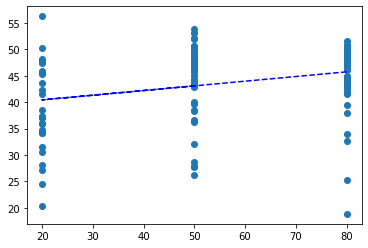

In [405]:
plt.scatter(x,y)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"b--")
X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

In [407]:
speed_A=[]
speed_B =[]
speed_C=[]
A_trial_times=[]
B_trial_times=[]
C_trial_times=[]
for ix in range(int(len(e2))):
    if e2.iloc[ix].trial_number_by_epoch!=0:
        if e2.iloc[ix].stem_switch==False: 
            if len(e2.iloc[ix].seg_switch_times) ==1:
                if e2.iloc[ix].stem =='A':
                    A_trial_times.append(e2.iloc[ix].seg_switch_times[0])
                if e2.iloc[ix].stem =='B':
                    B_trial_times.append(e2.iloc[ix].seg_switch_times[0])
                if trial_times.iloc[ix].stem =='C':
                    C_trial_times.append(e2.iloc[ix].seg_switch_times[0])
position_info = (IntervalPositionInfo() & {'nwb_file_name': nwb_file_name,
                                      'interval_list_name': f'pos 1 valid times',
                                      'position_info_param_name': 'default'}
                                    ).fetch1_dataframe()                    
                    
                    
for ix in range(len(A_trial_times)):
    time_at_center = A_trial_times[ix]
    time_start = time_at_center-1
    time_end = time_at_center+1
    speed_x,speed_y = get_speed_timestamp(time_start,time_end,position_info)
    speed_A.append(speed_y) 
for ix in range(len(B_trial_times)):
    time_at_center = B_trial_times[ix]
    time_start = time_at_center-1
    time_end = time_at_center+1
    speed_x,speed_y = get_speed_timestamp(time_start,time_end,position_info)
    speed_B.append(speed_y)
for ix in range(len(C_trial_times)):
    time_at_center = C_trial_times[ix]
    time_start = time_at_center-1
    time_end = time_at_center+1
    speed_x,speed_y = get_speed_timestamp(time_start,time_end,position_info)
    speed_C.append(speed_y)
                    

(array([ 2.,  1.,  3.,  8.,  3.,  4., 10., 15.,  9.,  6.]),
 array([20.1909266 , 25.32937663, 30.46782666, 35.6062767 , 40.74472673,
        45.88317676, 51.0216268 , 56.16007683, 61.29852686, 66.4369769 ,
        71.57542693]),
 <BarContainer object of 10 artists>)

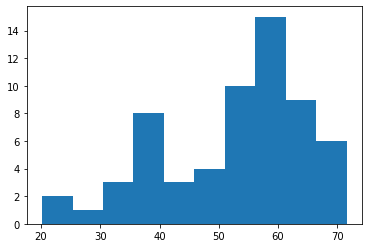

In [412]:
speed_keeper_A=[]
for ix in range(len(speed_A)):
    speed_temp = speed_A[ix]
    for deeper in range(len(speed_temp)):
        speed_keeper_A.append(speed_temp.iloc[deeper])
speed_keeper_B=[]
for ix in range(len(speed_B)):
    speed_temp = speed_B[ix]
    for deeper in range(len(speed_temp)):
        speed_keeper_B.append(speed_temp.iloc[deeper])
speed_keeper_C=[]
for ix in range(len(speed_C)):
    speed_temp = speed_C[ix]
    for deeper in range(len(speed_temp)):
        speed_keeper_C.append(speed_temp.iloc[deeper])

Text(0.5, 1.0, 'speeds at C, mean = 50.3426568925511')

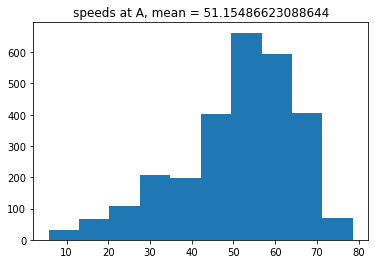

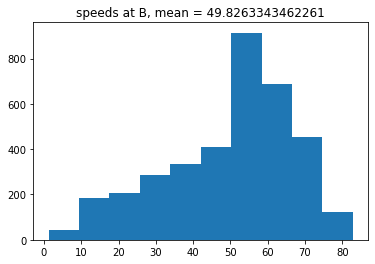

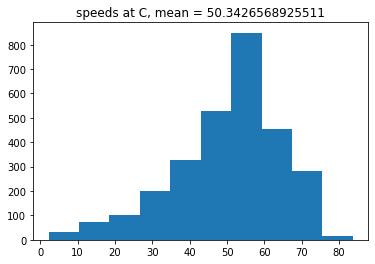

In [414]:
plt.hist(speed_keeper_A)
plt.title(f'speeds at A, mean = {statistics.mean(speed_keeper_A)}')
plt.figure()
plt.hist(speed_keeper_B)
plt.title(f'speeds at B, mean = {statistics.mean(speed_keeper_B)}')
plt.figure()
plt.hist(speed_keeper_C)
plt.title(f'speeds at C, mean = {statistics.mean(speed_keeper_C)}')



UFuncTypeError: Cannot cast ufunc 'lstsq_n' input 1 from dtype('O') to dtype('float64') with casting rule 'same_kind'

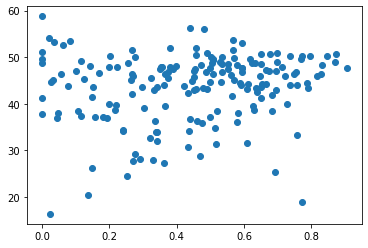

In [420]:
# plt.scatter(e2.rew_rate_ewm_stem[1:],e2.avg_speed_per_trial[1:])
x= e2.rew_rate_ewm_stem[1:]
y= e2.avg_speed_per_trial[1:]
plt.scatter(x,y)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"b--")
X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

In [424]:
e2.avg_speed_per_trial.iloc[0]

'NaN'

In [423]:
x

1      0.000000
2      0.000000
3      0.571429
4      0.756757
5      0.845714
         ...   
175    0.459422
176    0.594567
177    0.695925
178    0.771944
179    0.578958
Name: rew_rate_ewm_stem, Length: 179, dtype: float64

In [ ]:
# plot speeds across trials from above to make sure they dont in;cude much immobility 

avg_speed=[]
for ix in range(int(len(trial_times))):
    if trial_times.iloc[ix].trial_number_by_epoch!=0:
        if trial_times.iloc[ix].stem_switch==False: 
            if len(trial_times.iloc[ix].seg_switch_times) ==1: 
                time_at_center = trial_times.iloc[ix].seg_switch_times[0]
                time_start = time_at_center-1
                time_end = time_at_center+1
                epoch= trial_times.iloc[ix].epoch
                for epoch_ix in range(len(epoch_pos)):
                    if epoch_pos[epoch_ix][0]==epoch:
                        pos_num = epoch_pos[epoch_ix][1]
    
    #get the position and linearized position info for that epoch 
                position_info = (IntervalPositionInfo() &
                                 {'nwb_file_name': nwb_file_name,
                                  'interval_list_name': f'pos {pos_num} valid times',
                                  'position_info_param_name': 'default'}
                                ).fetch1_dataframe()
                speed_x,speed_y = get_speed_timestamp(time_start,time_end,position_info)
                plt.plot(range(len(speed_x)),speed_y)
plt.title('speed profiles for all stay trials, 1 second b4 and after segment change, 2 segment changes for day')
plt.xlabel('samples')
plt.ylabel('speed ( cm/s)')

In [28]:
Speed_trial=[]
for ix in range(int(len(trial_times))):
    if trial_times.iloc[ix].trial_number_by_epoch!=0:
        if trial_times.iloc[ix].stem_switch==False: 
            if len(trial_times.iloc[ix].seg_switch_times) ==1: 
                time_at_center = trial_times.iloc[ix].seg_switch_times[0]
                time_start = time_at_center-1
                time_end = time_at_center+1
                epoch= trial_times.iloc[ix].epoch
                for epoch_ix in range(len(epoch_pos)):
                    if epoch_pos[epoch_ix][0]==epoch:
                        pos_num = epoch_pos[epoch_ix][1]
    
    #get the position and linearized position info for that epoch 
                position_info = (IntervalPositionInfo() &
                                 {'nwb_file_name': nwb_file_name,
                                  'interval_list_name': f'pos {pos_num} valid times',
                                  'position_info_param_name': 'default'}
                                ).fetch1_dataframe()
                speed_x,speed_y = get_speed_timestamp(time_start,time_end,position_info)
                speed_y_keeper=[]
                for indiv_speed in range(len(speed_y)): 
                    speed_y_keeper.append(speed_y.iloc[indiv_speed])
                Speed_trial.append([speed_y_keeper])
                

In [51]:
position_info = (IntervalPositionInfo() & {'nwb_file_name': nwb_file_name,
                                  'interval_list_name': f'pos 1 valid times',
                                  'position_info_param_name': 'default'}
                                ).fetch1_dataframe()

In [53]:
e2 = trial_times[trial_times.epoch==2]

In [37]:
Speed_trial=[]
for ix in range(int(len(e2))):
    if e2.iloc[ix].trial_number_by_epoch!=0:
        if e2.iloc[ix].stem_switch==False: 
            if len(e2.iloc[ix].seg_switch_times) ==1: 
                time_at_center = e2.iloc[ix].seg_switch_times[0]
                time_start = time_at_center-1
                time_end = time_at_center+1
#                 epoch= e2.iloc[ix].epoch
#                 for epoch_ix in range(len(epoch_pos)):
#                     if epoch_pos[epoch_ix][0]==epoch:
#                         pos_num = epoch_pos[epoch_ix][1]
    
#     #get the position and linearized position info for that epoch 
#                 position_info = (IntervalPositionInfo() &
#                                  {'nwb_file_name': nwb_file_name,
#                                   'interval_list_name': f'pos {pos_num} valid times',
#                                   'position_info_param_name': 'default'}
#                                 ).fetch1_dataframe()
                speed_x,speed_y = get_speed_timestamp(time_start,time_end,position_info)
                speed_y_keeper=[]
                for indiv_speed in range(len(speed_y)): 
                    speed_y_keeper.append(speed_y.iloc[indiv_speed])
                Speed_trial.append([speed_y_keeper])

AttributeError: 'Series' object has no attribute 'seg_switch_times'

In [ ]:
for ix in range(int(len(Speed_trial)/4)):
    vals = Speed_trial[ix][0]
    arr = np.array(vals)[None, :] # arr.shape ⇒ (1, 10)
    ###   #######################
    plt.figure(figsize=(20,15))
    im = plt.imshow(arr, vmin=0, vmax=85,cmap='viridis')                
cbar = plt.colorbar(im, extend='both', orientation='horizontal')
cbar.cmap.set_under('purple') , cbar.cmap.set_over('yellow')
plt.xticks(range(len(vals))), plt.yticks(())
plt.show

In [ ]:
for ix in range(int(len(Speed_trial)/4)):
    vals = Speed_trial[ix][0]
    arr = np.array(vals)[None, :] # arr.shape ⇒ (1, 10)
    ###   #######################
    plt.figure(figsize=(20,15))
    im = plt.imshow(arr, vmin=0, vmax=85,cmap='viridis')                
cbar = plt.colorbar(im, extend='both', orientation='horizontal')
cbar.cmap.set_under('purple') , cbar.cmap.set_over('yellow')
plt.xticks(range(len(vals))), plt.yticks(())
plt.show

In [63]:
Speed_trial=[]
for ix in range(int(len(e2))):
    if e2.iloc[ix].trial_number_by_epoch!=0:
        if e2.iloc[ix+2].stem_switch==True: 
            if len(e2.iloc[ix].seg_switch_times) ==1: 
                time_at_center = e2.iloc[ix].seg_switch_times[0]
                time_start = time_at_center-1
                time_end = time_at_center+1
#                 epoch= e2.iloc[ix].epoch
#                 for epoch_ix in range(len(epoch_pos)):
#                     if epoch_pos[epoch_ix][0]==epoch:
#                         pos_num = epoch_pos[epoch_ix][1]
    
#     #get the position and linearized position info for that epoch 
#                 position_info = (IntervalPositionInfo() &
#                                  {'nwb_file_name': nwb_file_name,
#                                   'interval_list_name': f'pos {pos_num} valid times',
#                                   'position_info_param_name': 'default'}
#                                 ).fetch1_dataframe()
                speed_x,speed_y = get_speed_timestamp(time_start,time_end,position_info)
                speed_y_keeper=[]
                for indiv_speed in range(len(speed_y)): 
                    speed_y_keeper.append(speed_y.iloc[indiv_speed])
                Speed_trial.append([speed_y_keeper])

IndexError: single positional indexer is out-of-bounds

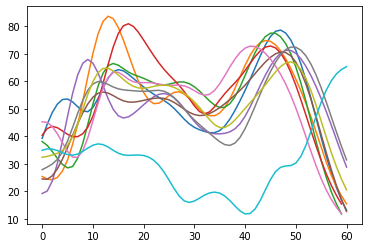

In [64]:
for ix in range(len(Speed_trial)):
    plt.plot(Speed_trial[ix][0])

IndexError: single positional indexer is out-of-bounds

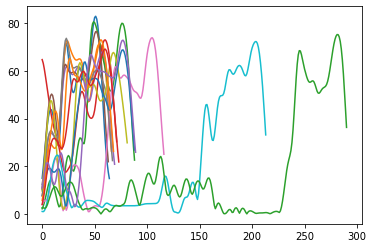

In [74]:
Speed_trial=[]
for ix in range(int(len(e2))):
    if e2.iloc[ix].trial_number_by_epoch!=0:
        if e2.iloc[ix+1].stem_switch==True: 
            if len(e2.iloc[ix].seg_switch_times) ==1: 
                plt.plot(e2.iloc[ix].speed_all_trial)

In [65]:
e2

,nwb_file_name,epoch,trial_number_by_epoch,leaf,stem,reward,poke_in_ts,reward_on_ts,reward_off_ts,poke_out_ts,...,stem_switch,trial_len,rew_rate_ewm_leaf,rew_rate_ewm_stem,rew_rate_ewm_epoch,seg_switch_times,avg_speed_per_trial,max_speed_per_trial,min_speed_per_trial,speed_all_trial
0,senor20201030_.nwb,2,0,4,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,True,NaN,0.000000,0.000000,0.000000,0,NaN,NaN,NaN,NaN
1,senor20201030_.nwb,2,1,3,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,False,2.156,0.000000,0.000000,0.000000,[1604078259.6768906],51.078441,82.84474,14.939608,"[15.062713307249425, 19.321927234376464, 24.02..."
2,senor20201030_.nwb,2,2,2,A,0,1.604078e+09,NaN,NaN,1.604078e+09,...,True,4.84,0.000000,0.000000,0.000000,"[1604078268.4768033, 1604078268.810136, 160407...",48.655067,73.394483,2.184796,"[16.376759798195184, 22.196654189333294, 28.52..."
3,senor20201030_.nwb,2,3,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,False,2.226,1.000000,0.571429,0.365714,[1604078279.2767003],49.832956,71.575427,9.793412,"[9.793411570687521, 13.531200487296626, 18.017..."
4,senor20201030_.nwb,2,4,2,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,False,3.727,0.571429,0.756757,0.573624,[1604078292.4099002],33.240799,72.046607,1.453074,"[4.325741268658773, 6.150507068352855, 8.32426..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,senor20201030_.nwb,2,175,6,C,0,1.604079e+09,NaN,NaN,1.604079e+09,...,False,3.237,0.488473,0.459422,0.459531,[1604079361.7658658],36.396941,73.42174,0.832136,"[3.227855992295253, 3.892456605176943, 4.43447..."
176,senor20201030_.nwb,2,176,5,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,False,2.484,0.689370,0.594567,0.594648,[1604079364.9991605],47.783901,67.189868,12.573764,"[12.573764293595621, 16.275568663912466, 20.15..."
177,senor20201030_.nwb,2,177,6,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,False,2.679,0.616427,0.695925,0.695986,[1604079372.9324226],42.932353,69.433113,2.320955,"[2.320955142127811, 2.917493797382179, 3.69255..."
178,senor20201030_.nwb,2,178,5,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,False,6.646,0.767052,0.771944,0.771990,[1604079385.2989662],18.862685,76.406325,0.031708,"[6.157542982641511, 7.724671484636717, 9.63843..."


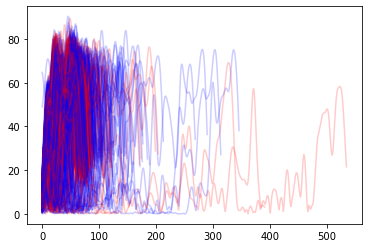

In [90]:
for ix in range(len(trial_times)-1): 
    if trial_times.iloc[ix].speed_all_trial != 'NaN':
        if trial_times.iloc[ix].stem_switch ==False:
            if trial_times.iloc[ix].rew_rate_ewm_leaf>.6:
                plt.plot(trial_times.iloc[ix].speed_all_trial,color='red',alpha=.2,label='high v')
            else:
                plt.plot(trial_times.iloc[ix].speed_all_trial,color='blue',alpha=.2,label='low v')
# plt.legend()

In [ ]:
for ix in range(len(trial_times)-1): 
    if trial_times.iloc[ix].speed_all_trial != 'NaN':
        if trial_times.iloc[ix].stem_switch ==False:
            if trial_times.iloc[ix].rew_rate_ewm_leaf>.6:
                segment_time = trial_times.iloc[ix]
#maybe he runs faster on the first segment if he knows hes going to get reward. 
#and maybe only when hes hungry and excited about finding the best place. Those are my ideas for what to look at tomorrow. 

In [15]:
Speed_trial_first=[]
Speed_trial_second=[]


for ix in range(int(len(e2))):
    if e2.iloc[ix].trial_number_by_epoch!=0:
        if e2.iloc[ix].stem_switch==False: 
            if len(e2.iloc[ix].seg_switch_times) ==1: 
                time_at_center = e2.iloc[ix].seg_switch_times[0]
                time_start = time_at_center-1
                time_end = time_at_center+1
#                 epoch= e2.iloc[ix].epoch
#                 for epoch_ix in range(len(epoch_pos)):
#                     if epoch_pos[epoch_ix][0]==epoch:
#                         pos_num = epoch_pos[epoch_ix][1]
    
#     #get the position and linearized position info for that epoch 
#                 position_info = (IntervalPositionInfo() &
#                                  {'nwb_file_name': nwb_file_name,
#                                   'interval_list_name': f'pos {pos_num} valid times',
#                                   'position_info_param_name': 'default'}
#                                 ).fetch1_dataframe()
                speed_x,speed_y_first_seg = get_speed_timestamp(time_start,time_at_center,position_info)
                speed_x,speed_y_second_seg = get_speed_timestamp(time_at_center,time_end,position_info)

    
                speed_y_keeper_first_seg=[]
                for indiv_speed in range(len(speed_y_first_seg)): 
                    speed_y_keeper_first_seg.append(speed_y_first_seg.iloc[indiv_speed])
                Speed_trial_first.append([speed_y_keeper_first_seg])
                
                speed_y_keeper_second_seg=[]
                for indiv_speed in range(len(speed_y_second_seg)): 
                    speed_y_keeper_second_seg.append(speed_y_second_seg.iloc[indiv_speed])
                Speed_trial_second.append([speed_y_keeper_second_seg])

AttributeError: 'Series' object has no attribute 'seg_switch_times'

In [60]:
trial_times

,nwb_file_name,epoch,trial_number_by_epoch,leaf,stem,reward,poke_in_ts,reward_on_ts,reward_off_ts,poke_out_ts,...,stem_switch,trial_len,rew_rate_ewm_leaf,rew_rate_ewm_stem,rew_rate_ewm_epoch,seg_switch_times,avg_speed_per_trial,max_speed_per_trial,min_speed_per_trial,speed_all_trial
0,senor20201030_.nwb,2,0,4,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,True,NaN,0.000000,0.000000,0.000000,0,NaN,NaN,NaN,NaN
1,senor20201030_.nwb,2,1,3,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,False,2.156,0.000000,0.000000,0.000000,[1604078259.6768906],51.078441,82.84474,14.939608,"[15.062713307249425, 19.321927234376464, 24.02..."
2,senor20201030_.nwb,2,2,2,A,0,1.604078e+09,NaN,NaN,1.604078e+09,...,True,4.84,0.000000,0.000000,0.000000,"[1604078268.4768033, 1604078268.810136, 160407...",48.655067,73.394483,2.184796,"[16.376759798195184, 22.196654189333294, 28.52..."
3,senor20201030_.nwb,2,3,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,False,2.226,1.000000,0.512195,0.268583,[1604078279.2767003],49.832956,71.575427,9.793412,"[9.793411570687521, 13.531200487296626, 18.017..."
4,senor20201030_.nwb,2,4,2,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,False,3.727,0.512195,0.682791,0.429477,[1604078292.4099002],33.240799,72.046607,1.453074,"[4.325741268658773, 6.150507068352855, 8.32426..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,senor20201030_.nwb,14,175,1,A,0,1.604104e+09,NaN,NaN,1.604104e+09,...,False,2.73,0.484233,0.423502,0.392555,[1604103536.0823658],42.377209,69.27256,3.97578,"[11.78316489530877, 15.58515467318779, 19.1058..."
1256,senor20201030_.nwb,14,176,2,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,False,2.67,0.442383,0.452865,0.421487,[1604103539.3156853],42.638762,66.655695,5.594969,"[5.594969397402997, 8.612097514627141, 12.4385..."
1257,senor20201030_.nwb,14,177,1,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,False,2.462,0.516675,0.480641,0.449039,[1604103545.7489443],46.99723,68.021411,15.905849,"[15.90584921995597, 20.113960355128164, 24.225..."
1258,senor20201030_.nwb,14,178,2,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,False,2.298,0.477458,0.506923,0.475280,[1604103552.8488734],48.893069,68.078626,10.117551,"[10.11755100990477, 13.7862750854686, 18.08672..."


In [33]:
trial_times

,nwb_file_name,epoch,trial_number_by_epoch,leaf,stem,reward,poke_in_ts,reward_on_ts,reward_off_ts,poke_out_ts,...,p_rew_reset_leaf2,p_rew_reset_leaf3,p_rew_reset_leaf4,p_rew_reset_leaf5,p_rew_reset_leaf6,stem_switch,trial_len,rew_rate_ewm_leaf,rew_rate_ewm_stem,rew_rate_ewm_epoch
0,senor20201030_.nwb,2,0,4,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,NaN,NaN,NaN,NaN,NaN,True,NaN,0.000000,0.000000,0.000000
1,senor20201030_.nwb,2,1,3,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,NaN,NaN,NaN,NaN,NaN,False,2.156,0.000000,0.000000,0.000000
2,senor20201030_.nwb,2,2,2,A,0,1.604078e+09,NaN,NaN,1.604078e+09,...,NaN,NaN,NaN,NaN,NaN,True,4.84,0.000000,0.000000,0.000000
3,senor20201030_.nwb,2,3,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,NaN,NaN,NaN,NaN,NaN,False,2.226,1.000000,0.571429,0.365714
4,senor20201030_.nwb,2,4,2,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,NaN,NaN,NaN,NaN,NaN,False,3.727,0.571429,0.756757,0.573624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,senor20201030_.nwb,14,175,1,A,0,1.604104e+09,NaN,NaN,1.604104e+09,...,NaN,NaN,NaN,NaN,NaN,False,2.73,0.538468,0.283583,0.337306
1256,senor20201030_.nwb,14,176,2,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,NaN,NaN,NaN,NaN,NaN,False,2.67,0.334064,0.462688,0.502979
1257,senor20201030_.nwb,14,177,1,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,NaN,NaN,NaN,NaN,NaN,False,2.462,0.653879,0.597016,0.627234
1258,senor20201030_.nwb,14,178,2,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,NaN,NaN,NaN,NaN,NaN,False,2.298,0.500588,0.697762,0.720426


In [388]:
epoch_2 = trial_times[trial_times.epoch==4]

In [127]:
epoch_2

,nwb_file_name,epoch,trial_number_by_epoch,leaf,stem,reward,poke_in_ts,reward_on_ts,reward_off_ts,poke_out_ts,...,trial_len,rew_rate_ewm_leaf,rew_rate_ewm_stem,rew_rate_ewm_epoch,seg_switch_times,avg_speed_per_trial,max_speed_per_trial,min_speed_per_trial,speed_all_trial,trial_speeds_1s
0,senor20201030_.nwb,2,0,4,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,NaN,0.000000,0.000000,0.000000,0,NaN,NaN,NaN,NaN,[0]
1,senor20201030_.nwb,2,1,3,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,2.156,0.000000,0.000000,0.000000,[1604078259.6768906],51.078441,82.84474,14.939608,"[15.062713307249425, 19.321927234376464, 24.02...","[[42.95127214991963, 43.86733681223068, 43.580..."
2,senor20201030_.nwb,2,2,2,A,0,1.604078e+09,NaN,NaN,1.604078e+09,...,4.84,0.000000,0.000000,0.000000,"[1604078268.4768033, 1604078268.810136, 160407...",48.655067,73.394483,2.184796,"[16.376759798195184, 22.196654189333294, 28.52...",[0]
3,senor20201030_.nwb,2,3,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,2.226,1.000000,0.512195,0.268583,[1604078279.2767003],49.832956,71.575427,9.793412,"[9.793411570687521, 13.531200487296626, 18.017...","[[32.57568279012766, 36.10792852734244, 38.296..."
4,senor20201030_.nwb,2,4,2,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,3.727,0.512195,0.682791,0.429477,[1604078292.4099002],33.240799,72.046607,1.453074,"[4.325741268658773, 6.150507068352855, 8.32426...","[[22.56292524021044, 24.788513641690827, 28.07..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,senor20201030_.nwb,2,175,6,C,0,1.604079e+09,NaN,NaN,1.604079e+09,...,3.237,0.494140,0.508119,0.514689,[1604079361.7658658],36.396941,73.42174,0.832136,"[3.227855992295253, 3.892456605176943, 4.43447...","[[30.11178121253213, 29.79818328811826, 29.080..."
176,senor20201030_.nwb,2,176,5,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,2.484,0.501610,0.533553,0.537803,[1604079364.9991605],47.783901,67.189868,12.573764,"[12.573764293595621, 16.275568663912466, 20.15...","[[38.69587181921599, 39.187237695970055, 38.79..."
177,senor20201030_.nwb,2,177,6,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,2.679,0.527654,0.557575,0.559816,[1604079372.9324226],42.932353,69.433113,2.320955,"[2.320955142127811, 2.917493797382179, 3.69255...","[[40.501339130677664, 41.08480871257926, 39.95..."
178,senor20201030_.nwb,2,178,5,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,6.646,0.533470,0.580271,0.580781,[1604079385.2989662],18.862685,76.406325,0.031708,"[6.157542982641511, 7.724671484636717, 9.63843...","[[36.92566264839194, 42.04427006923697, 47.343..."


In [374]:
epoch_2.iloc[1].trial_speeds_1s[0]# !=0
# ix

time
1.604083e+09    38.532136
1.604083e+09    42.137124
1.604083e+09    47.193019
1.604083e+09    53.283996
1.604083e+09    59.560612
                  ...    
1.604083e+09    10.041887
1.604083e+09     7.921391
1.604083e+09     6.521645
1.604083e+09     5.548612
1.604083e+09     4.705494
Name: head_speed, Length: 61, dtype: float64

In [389]:
#this is my way of brekaing apart the weird series structure of the speeds, making them into lists. 
speed_trial
speed_keeper_all=[]
for trial in range(len(epoch_2)):
    one_trial = epoch_2.iloc[trial].trial_speeds_1s[0]
    if type(one_trial) != int:
        speed_keeper_first=[]
        for ix in range(len(one_trial)):
            speed_keeper_first.append(one_trial.iloc[ix])
        speed_keeper_all.append(speed_keeper_first)
        
    else:
        speed_keeper_all.append(0)
            # speed_all.append([speed_keeper_first])

In [391]:
# for ix in range(len(speed_keeper_all)):
#     speed_one_trial = speed_keeper_all[ix]
epoch_2['trials_s_lst']=speed_keeper_all    

In [178]:
epoch_2

,nwb_file_name,epoch,trial_number_by_epoch,leaf,stem,reward,poke_in_ts,reward_on_ts,reward_off_ts,poke_out_ts,...,rew_rate_ewm_leaf,rew_rate_ewm_stem,rew_rate_ewm_epoch,seg_switch_times,avg_speed_per_trial,max_speed_per_trial,min_speed_per_trial,speed_all_trial,trial_speeds_1s,trials_s_lst
0,senor20201030_.nwb,2,0,4,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,0.000000,0.000000,0.000000,0,NaN,NaN,NaN,NaN,[0],0
1,senor20201030_.nwb,2,1,3,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,0.000000,0.000000,0.000000,[1604078259.6768906],51.078441,82.84474,14.939608,"[15.062713307249425, 19.321927234376464, 24.02...","[[42.95127214991963, 43.86733681223068, 43.580...","[42.95127214991963, 43.86733681223068, 43.5804..."
2,senor20201030_.nwb,2,2,2,A,0,1.604078e+09,NaN,NaN,1.604078e+09,...,0.000000,0.000000,0.000000,"[1604078268.4768033, 1604078268.810136, 160407...",48.655067,73.394483,2.184796,"[16.376759798195184, 22.196654189333294, 28.52...",[0],0
3,senor20201030_.nwb,2,3,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,1.000000,0.512195,0.268583,[1604078279.2767003],49.832956,71.575427,9.793412,"[9.793411570687521, 13.531200487296626, 18.017...","[[32.57568279012766, 36.10792852734244, 38.296...","[32.57568279012766, 36.10792852734244, 38.2960..."
4,senor20201030_.nwb,2,4,2,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,0.512195,0.682791,0.429477,[1604078292.4099002],33.240799,72.046607,1.453074,"[4.325741268658773, 6.150507068352855, 8.32426...","[[22.56292524021044, 24.788513641690827, 28.07...","[22.56292524021044, 24.788513641690827, 28.073..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,senor20201030_.nwb,2,175,6,C,0,1.604079e+09,NaN,NaN,1.604079e+09,...,0.494140,0.508119,0.514689,[1604079361.7658658],36.396941,73.42174,0.832136,"[3.227855992295253, 3.892456605176943, 4.43447...","[[30.11178121253213, 29.79818328811826, 29.080...","[30.11178121253213, 29.79818328811826, 29.0801..."
176,senor20201030_.nwb,2,176,5,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,0.501610,0.533553,0.537803,[1604079364.9991605],47.783901,67.189868,12.573764,"[12.573764293595621, 16.275568663912466, 20.15...","[[38.69587181921599, 39.187237695970055, 38.79...","[38.69587181921599, 39.187237695970055, 38.793..."
177,senor20201030_.nwb,2,177,6,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,0.527654,0.557575,0.559816,[1604079372.9324226],42.932353,69.433113,2.320955,"[2.320955142127811, 2.917493797382179, 3.69255...","[[40.501339130677664, 41.08480871257926, 39.95...","[40.501339130677664, 41.08480871257926, 39.956..."
178,senor20201030_.nwb,2,178,5,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,0.533470,0.580271,0.580781,[1604079385.2989662],18.862685,76.406325,0.031708,"[6.157542982641511, 7.724671484636717, 9.63843...","[[36.92566264839194, 42.04427006923697, 47.343...","[36.92566264839194, 42.04427006923697, 47.3430..."


In [392]:
epoch_2['bout_num'] = epoch_2['stem'].ne(epoch_2['stem'].shift()).cumsum()


#adding the length of each bout 
bout_len_lst=[]
for ix in range(1,(epoch_2.bout_num.max()+1)):
    bout_len = len(epoch_2[epoch_2.bout_num == ix])
    bout_len_lst.append((np.ones(bout_len)*bout_len).tolist())
bout_len_list = [item for sublist in bout_len_lst for item in sublist]

epoch_2['bout_lens_per_bout']=bout_len_list

long_bouts = epoch_2[epoch_2.bout_lens_per_bout>15]

In [ ]:
for ix in range(1,int(len(epoch_2))):
    if epoch_2.iloc[ix].trials_s_lst !=0:
        if epoch_2.iloc[ix].stem_switch == False:
            vals = epoch_2.iloc[ix].trials_s_lst
            # vals = epoch_2[ix][0]
            arr = np.array(vals)[None, :] # arr.shape ⇒ (1, 10)
            ###   #######################
            plt.figure(figsize=(20,15))
            im = plt.imshow(arr, vmin=0, vmax=85,cmap='viridis')                
cbar = plt.colorbar(im, extend='both', orientation='horizontal')
cbar.cmap.set_under('purple') , cbar.cmap.set_over('yellow')
plt.xticks(range(len(vals))), plt.yticks(())
plt.show

In [ ]:
vals =[]
for ix in range(1,int(len(epoch_2))):
    if epoch_2.iloc[ix].trials_s_lst !=0:
        if epoch_2.iloc[ix].stem_switch == False:
            vals.append(epoch_2.iloc[ix].trials_s_lst)
            
num_rows = len(vals)

fig, axs = plt.subplots(nrows=num_rows, ncols=1, figsize=(200,100))
# axs.xaxis.set_major_locator(plt.NullLocator())
# axs.yaxis.set_major_locator(plt.NullLocator())

for ix in range(len(vals)):
    speeds = vals[ix]
    arr = np.array(speeds)[None, :]
    im = axs[ix].imshow(arr, vmin=0, vmax=85,cmap='viridis')

    
            
#             vals = epoch_2.iloc[ix].trials_s_lst
#             # vals = epoch_2[ix][0]
#             arr = np.array(vals)[None, :] # arr.shape ⇒ (1, 10)
#             ###   #######################
#             plt.figure(figsize=(20,15))
#             im = plt.imshow(arr, vmin=0, vmax=85,cmap='viridis')                
# cbar = plt.colorbar(im, extend='both', orientation='horizontal')
# cbar.cmap.set_under('purple') , cbar.cmap.set_over('yellow')
# plt.xticks(range(len(vals))), plt.yticks(())
# plt.show

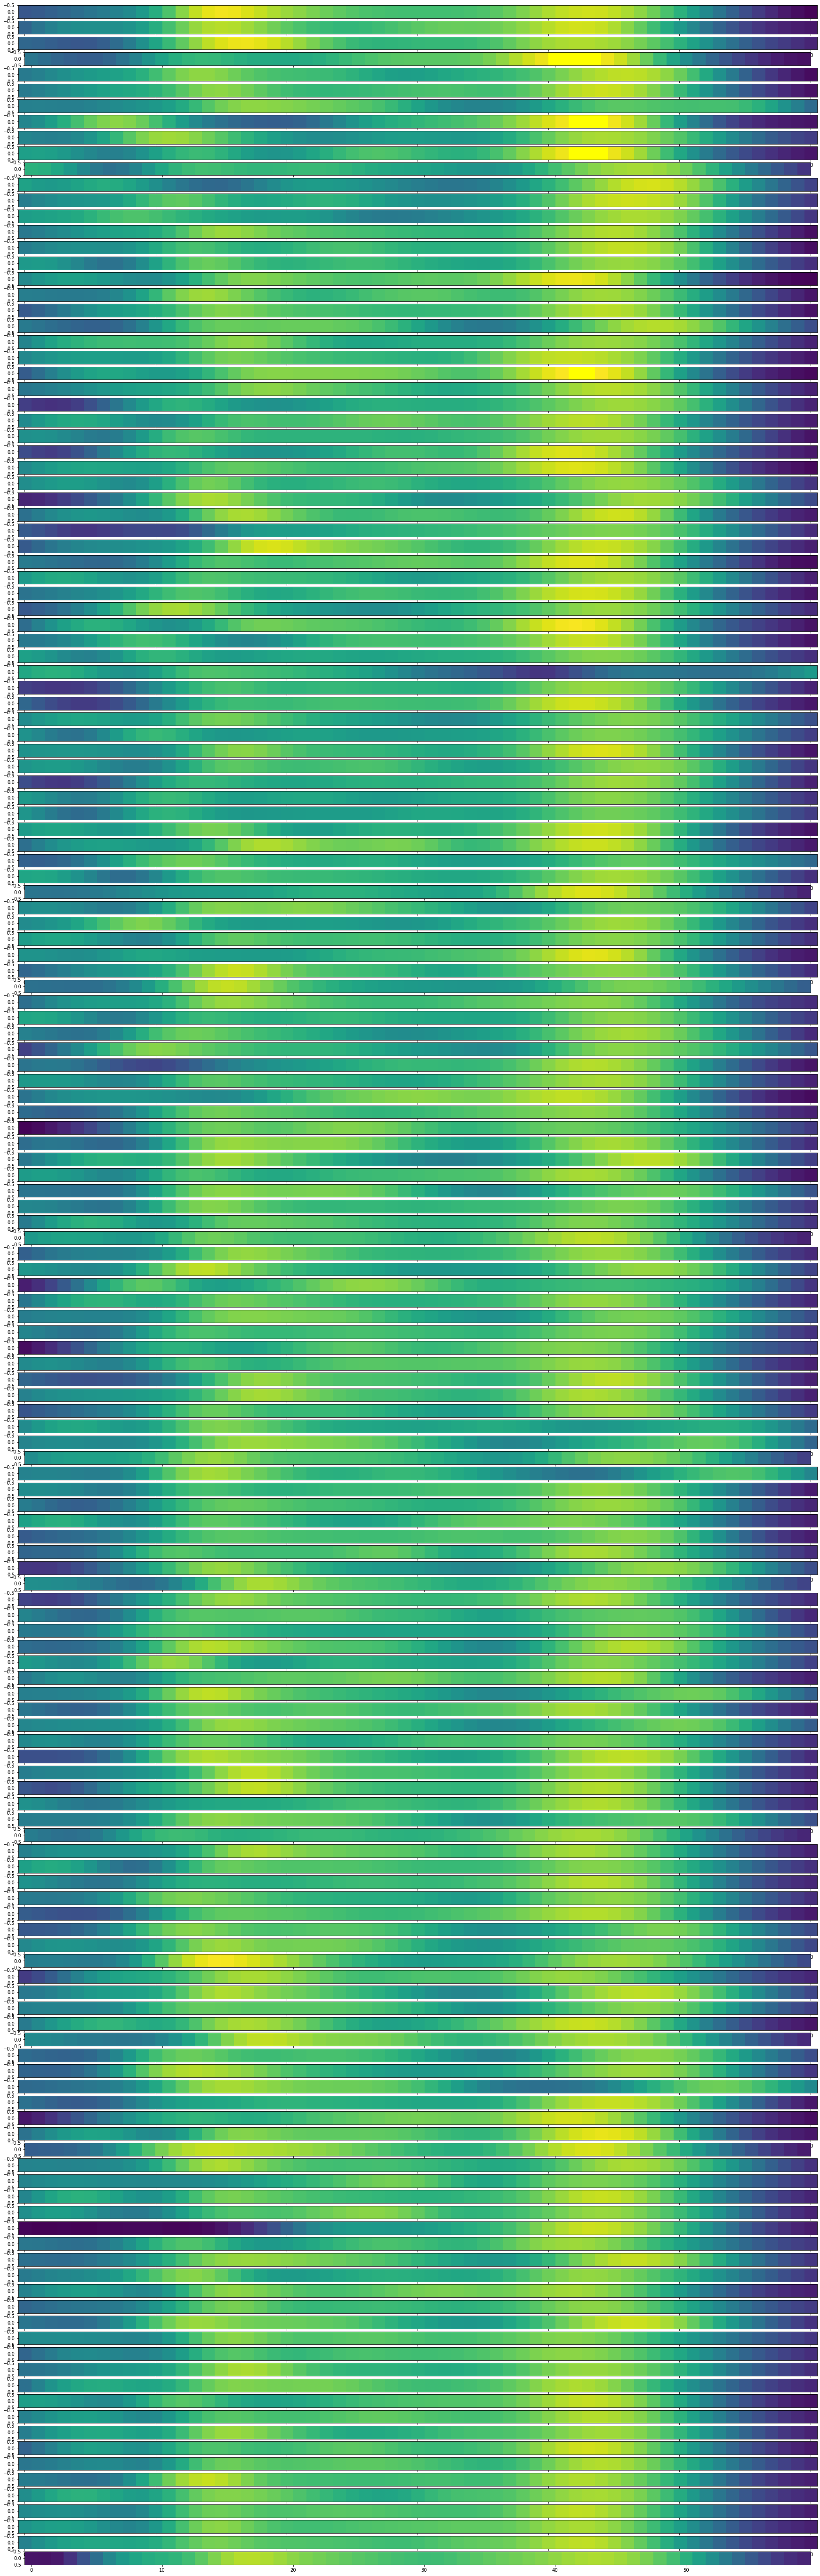

In [393]:
vals =[]

for ix in range(1,int(len(epoch_2))):
    if epoch_2.iloc[ix].trials_s_lst !=0:
        if epoch_2.iloc[ix].stem_switch == False:
            # if epoch_2.iloc[ix].bout_lens_per_bout>15:
            vals.append([epoch_2.iloc[ix].rew_rate_ewm_leaf,epoch_2.iloc[ix].trials_s_lst])
vals.sort()

            
num_rows = len(vals)

fig, axs = plt.subplots(nrows=num_rows, ncols=1, figsize=(200,100))


for ix in range(len(vals)):
    speeds = vals[ix][1]
    arr = np.array(speeds)[None, :]
    im = axs[ix].imshow(arr, vmin=0, vmax=85,cmap='viridis')

    
            
#             vals = epoch_2.iloc[ix].trials_s_lst
#             # vals = epoch_2[ix][0]
#             arr = np.array(vals)[None, :] # arr.shape ⇒ (1, 10)
#             ###   #######################
#             plt.figure(figsize=(20,15))
#             im = plt.imshow(arr, vmin=0, vmax=85,cmap='viridis')                
# cbar = plt.colorbar(im, extend='both', orientation='horizontal')
# cbar.cmap.set_under('purple') , cbar.cmap.set_over('yellow')
# plt.xticks(range(len(vals))), plt.yticks(())
# plt.show

Text(0, 0.5, 'bout_len')

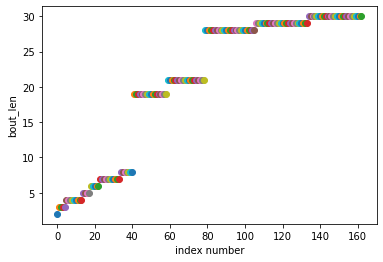

In [383]:
for ix in range(len(vals)):
    speeds = vals[ix][0]
    plt.scatter(ix, speeds)
plt.xlabel('index number')
plt.ylabel('bout_len')

In [363]:
speeds

1.0

In [184]:
epoch_2.iloc[ix].trials_s_lst

0

In [124]:
#went up to the top and added 1s before and after segment switch time to add speeds to df so that tehyre all similar legnth 

In [ ]:
#speedzs and value i nthe same list

In [276]:
epoch_2

,nwb_file_name,epoch,trial_number_by_epoch,leaf,stem,reward,poke_in_ts,reward_on_ts,reward_off_ts,poke_out_ts,...,rew_rate_ewm_leaf,rew_rate_ewm_stem,rew_rate_ewm_epoch,seg_switch_times,avg_speed_per_trial,max_speed_per_trial,min_speed_per_trial,speed_all_trial,trial_speeds_1s,trials_s_lst
0,senor20201030_.nwb,2,0,4,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,0.000000,0.000000,0.000000,0,NaN,NaN,NaN,NaN,[0],0
1,senor20201030_.nwb,2,1,3,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,0.000000,0.000000,0.000000,[1604078259.6768906],51.078441,82.84474,14.939608,"[15.062713307249425, 19.321927234376464, 24.02...","[[42.95127214991963, 43.86733681223068, 43.580...","[42.95127214991963, 43.86733681223068, 43.5804..."
2,senor20201030_.nwb,2,2,2,A,0,1.604078e+09,NaN,NaN,1.604078e+09,...,0.000000,0.000000,0.000000,"[1604078268.4768033, 1604078268.810136, 160407...",48.655067,73.394483,2.184796,"[16.376759798195184, 22.196654189333294, 28.52...",[0],0
3,senor20201030_.nwb,2,3,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,1.000000,0.512195,0.268583,[1604078279.2767003],49.832956,71.575427,9.793412,"[9.793411570687521, 13.531200487296626, 18.017...","[[32.57568279012766, 36.10792852734244, 38.296...","[32.57568279012766, 36.10792852734244, 38.2960..."
4,senor20201030_.nwb,2,4,2,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,0.512195,0.682791,0.429477,[1604078292.4099002],33.240799,72.046607,1.453074,"[4.325741268658773, 6.150507068352855, 8.32426...","[[22.56292524021044, 24.788513641690827, 28.07...","[22.56292524021044, 24.788513641690827, 28.073..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,senor20201030_.nwb,2,175,6,C,0,1.604079e+09,NaN,NaN,1.604079e+09,...,0.494140,0.508119,0.514689,[1604079361.7658658],36.396941,73.42174,0.832136,"[3.227855992295253, 3.892456605176943, 4.43447...","[[30.11178121253213, 29.79818328811826, 29.080...","[30.11178121253213, 29.79818328811826, 29.0801..."
176,senor20201030_.nwb,2,176,5,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,0.501610,0.533553,0.537803,[1604079364.9991605],47.783901,67.189868,12.573764,"[12.573764293595621, 16.275568663912466, 20.15...","[[38.69587181921599, 39.187237695970055, 38.79...","[38.69587181921599, 39.187237695970055, 38.793..."
177,senor20201030_.nwb,2,177,6,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,0.527654,0.557575,0.559816,[1604079372.9324226],42.932353,69.433113,2.320955,"[2.320955142127811, 2.917493797382179, 3.69255...","[[40.501339130677664, 41.08480871257926, 39.95...","[40.501339130677664, 41.08480871257926, 39.956..."
178,senor20201030_.nwb,2,178,5,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,0.533470,0.580271,0.580781,[1604079385.2989662],18.862685,76.406325,0.031708,"[6.157542982641511, 7.724671484636717, 9.63843...","[[36.92566264839194, 42.04427006923697, 47.343...","[36.92566264839194, 42.04427006923697, 47.3430..."


In [286]:
leaf_and_speed=[]
epoch_and_speed=[]

for ix in range(len(epoch_2)):
    if epoch_2.iloc[ix].trials_s_lst !=0:
        # if epoch_2.iloc[ix].stem_switch== False:
        leaf_and_speed.append([epoch_2.iloc[ix].rew_rate_ewm_leaf, epoch_2.iloc[ix].trials_s_lst])
        epoch_and_speed.append([epoch_2.iloc[ix].rew_rate_ewm_epoch, epoch_2.iloc[ix].trials_s_lst])
leaf_and_speed.sort()
epoch_and_speed.sort()

In [287]:
leaf_and_speed.sort()
epoch_and_speed.sort()

In [289]:
# for ix in range(1,int(len(leaf_and_speed))):
#     vals = leaf_and_speed[ix][1]
#         # vals = epoch_2[ix][0]
#     arr = np.array(vals)[None, :] # arr.shape ⇒ (1, 10)
#         ###   #######################
#     # plt.figure(figsize=(20,15))
#     plt.plot(vals,color='g',alpha= ix/(2*(len(epoch_and_speed))))


# #     im = plt.imshow(arr, vmin=0, vmax=85,cmap='viridis')                
# # cbar = plt.colorbar(im, extend='both', orientation='horizontal')
# # cbar.cmap.set_under('purple') , cbar.cmap.set_over('yellow')
# # plt.xticks(range(len(vals))), plt.yticks(())
# # plt.show

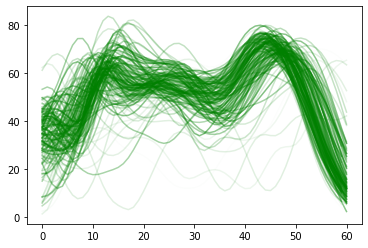

In [342]:
for ix in range(1,int(len(epoch_and_speed))):
    vals = epoch_and_speed[ix][1]
        # vals = epoch_2[ix][0]
    arr = np.array(vals)[None, :] # arr.shape ⇒ (1, 10)
        ###   #######################
    # plt.figure(figsize=(20,15))
    plt.plot(vals,color='g',alpha= ix/(2*(len(epoch_and_speed))))
#     im = plt.imshow(arr, vmin=0, vmax=85,cmap='viridis')                
# cbar = plt.colorbar(im, extend='both', orientation='horizontal')
# cbar.cmap.set_under('purple') , cbar.cmap.set_over('yellow')
# plt.xticks(range(len(vals))), plt.yticks(())
# plt.show

In [208]:
#random, just to give pos/neg results

Text(0, 0.5, 'avg speed')

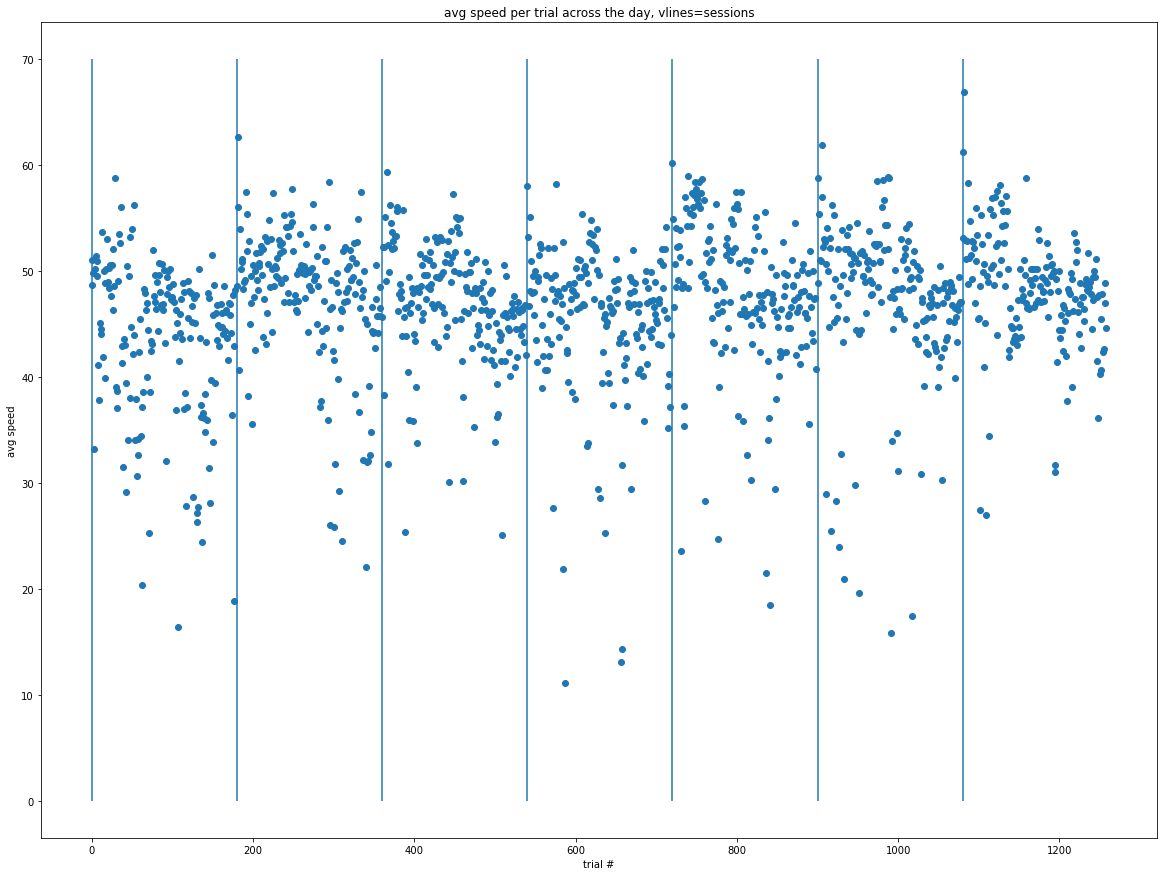

In [219]:

# plt.figure(figsize=(20,15))
# plt.scatter(range(len(trial_times.avg_speed_per_trial[1:])),trial_times.avg_speed_per_trial[1:])
# for ix in range(0,int(trial_times.epoch.max()*180/2),180):
#     plt.vlines(ix, 0,70)
# plt.title('avg speed per trial across the day, vlines=sessions')
# plt.xlabel('trial #')
# plt.ylabel('avg speed')

Text(0, 0.5, 'avg speed')

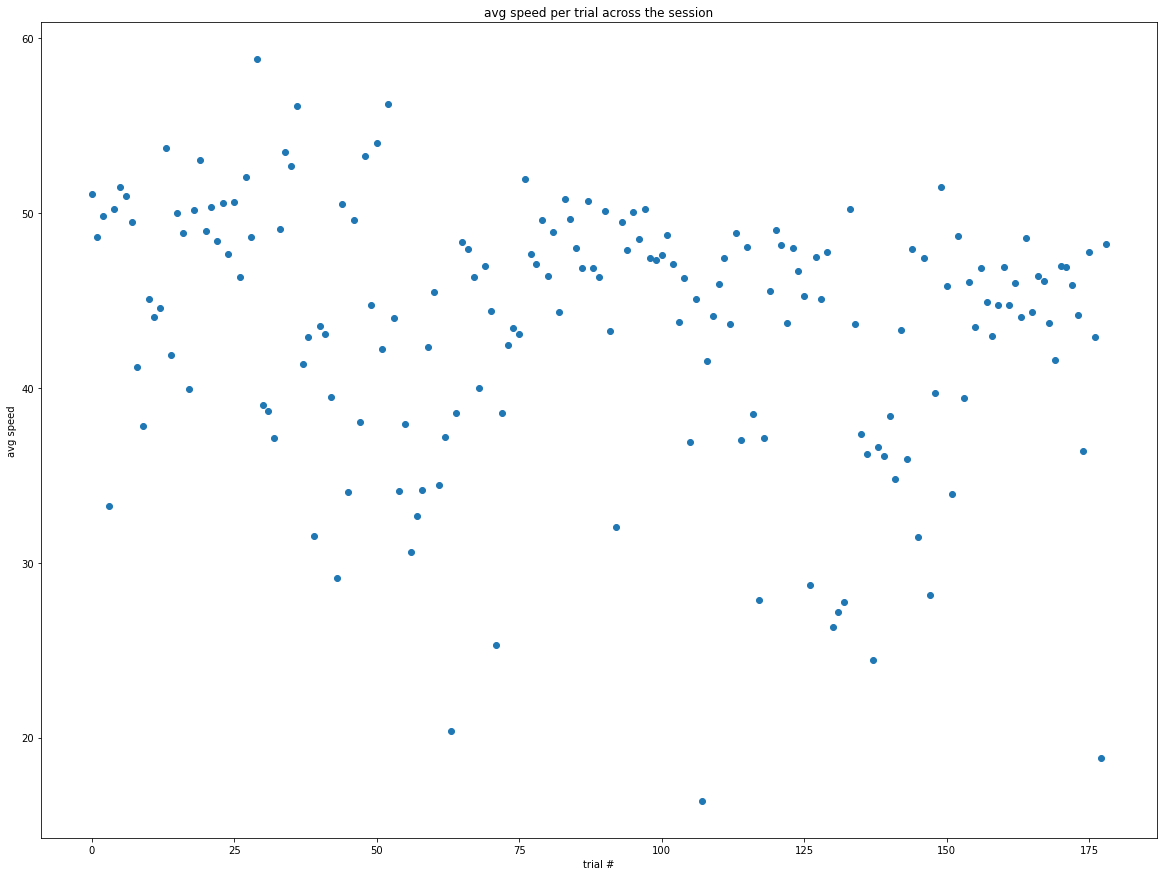

In [220]:
# plt.figure(figsize=(20,15))
# plt.scatter(range(len(e2.avg_speed_per_trial[1:])),e2.avg_speed_per_trial[1:])
# # for ix in range(0,int(trial_times.epoch.max()*180/2),180):
# #     plt.vlines(ix, 0,70)
# plt.title('avg speed per trial across the session')
# plt.xlabel('trial #')
# plt.ylabel('avg speed')

In [210]:
trial_times.avg_speed_per_trial

0             NaN
1       51.078441
2       48.655067
3       49.832956
4       33.240799
          ...    
1255    42.377209
1256    42.638762
1257     46.99723
1258    48.893069
1259    44.622045
Name: avg_speed_per_trial, Length: 1260, dtype: object

In [ ]:
epoch_and_speed

In [339]:
leaf_and_speed=[]
epoch_and_speed=[]
# rew_and_speed=[]
# no_rew_and_speed=[]

for ix in range(len(epoch_2)):
    if epoch_2.iloc[ix].trials_s_lst !=0:
        if epoch_2.iloc[ix].stem_switch== False:
            # if epoch_2.iloc[ix-1].reward ==1:
            
            leaf_and_speed.append([epoch_2.iloc[ix].rew_rate_ewm_leaf, epoch_2.iloc[ix].trials_s_lst])
            epoch_and_speed.append([epoch_2.iloc[ix].rew_rate_ewm_epoch, epoch_2.iloc[ix].trials_s_lst])
            #     rew_and_speed.append(epoch_2.iloc[ix].trials_s_lst)
            # else:
            #     no_rew_and_speed.append(epoch_2.iloc[ix].trials_s_lst)                     
leaf_and_speed.sort()
epoch_and_speed.sort()

In [340]:
low_val=[]
medium_val=[]
high_val=[]
for ix in range(len(leaf_and_speed)):
    if leaf_and_speed[ix][0]<.33:
        low_val.append(leaf_and_speed[ix][1])
    elif leaf_and_speed[ix][0] >=.33:
        if leaf_and_speed[ix][0] <.66:
            medium_val.append(leaf_and_speed[ix][1])
        else:
            high_val.append(leaf_and_speed[ix][1])
            
                       

# low_val = leaf_and_speed[0:int(len(leaf_and_speed)/2)]
# high_val = leaf_and_speed[int(len(leaf_and_speed)/2):]

Text(0, 0.5, 'avg speeds')

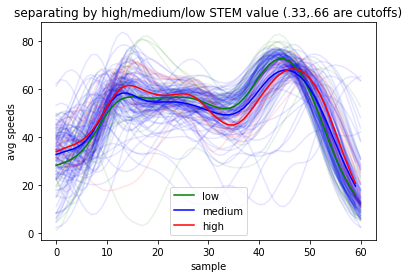

In [341]:
for ix in range(len(low_val)):   
    plt.plot(low_val[ix],alpha=.1,color='g')
for ix in range(len(medium_val)):
    plt.plot(medium_val[ix],alpha=.1,color='blue')
for ix in range(len(high_val)):
    plt.plot(high_val[ix],alpha=.1,color='r')
avg_low = [float(sum(col))/len(col) for col in zip(*low_val)]
avg_medium = [float(sum(col))/len(col) for col in zip(*medium_val)]
avg_high = [float(sum(col))/len(col) for col in zip(*high_val)]
plt.plot(avg_low,color='g', label='low')
plt.plot(avg_medium,color='blue',label = 'medium')
plt.plot(avg_high,color='r', label='high')

plt.legend()
plt.title('separating by high/medium/low STEM value (.33,.66 are cutoffs)')
plt.xlabel('sample')
plt.ylabel('avg speeds')




In [233]:
len(low_val)

76

In [296]:
# for ix in range(len(high_val)):
#     plt.plot(low_val[ix][1],alpha=.5,color='g')
#     # plt.plot(statistics.mean
#     plt.plot(high_val[ix][1],alpha=.5,color='r')
# plt.title('low vs high value (epoch based ewm), one epoch - low = g, high = r')
# plt.xlabel('sample')
# plt.ylabel('speed (cm/s)')


                

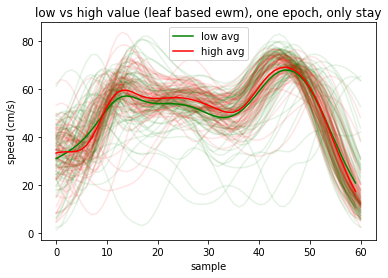

In [298]:
speeds_low=[]
speeds_high=[]
for ix in range(len(low_val)):
    speeds_low.append(low_val[ix][1])
    speeds_high.append(high_val[ix][1])
from statistics import mean

# plt.plot(
avg_low = [float(sum(col))/len(col) for col in zip(*speeds_low)]
avg_high = [float(sum(col))/len(col) for col in zip(*speeds_high)]




for ix in range(len(high_val)):
    plt.plot(low_val[ix][1],alpha=.1,color='g')
#     # plt.plot(statistics.mean
    plt.plot(high_val[ix][1],alpha=.1,color='r')
plt.title('low vs high value (leaf based ewm), one epoch, only stay')
plt.xlabel('sample')
plt.ylabel('speed (cm/s)')

plt.plot(avg_low,color='g', alpha=1,label = 'low avg')
plt.plot(avg_high,color='r', alpha=1, label= 'high avg')
plt.legend()

   

Text(0, 0.5, 'speed (cm/s)')

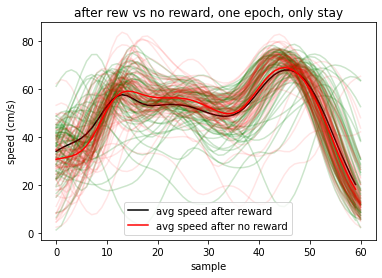

In [319]:
for ix in range(len(rew_and_speed)):
    plt.plot(rew_and_speed[ix],alpha=.2,color='g')
# rew_and_speed = np.asarray(rew_and_speed)
avg_rew = [float(sum(col))/len(col) for col in zip(*rew_and_speed)]
plt.plot(avg_rew, label='avg speed after reward',color='black')

for ix in range(len(no_rew_and_speed)):
    plt.plot(no_rew_and_speed[ix],alpha=.1,color='r')
# # rew_and_speed = np.asarray(rew_and_speed)
avg_rew = [float(sum(col))/len(col) for col in zip(*no_rew_and_speed)]
plt.plot(avg_rew, label='avg speed after no reward',color='r',alpha=1)
plt.legend()
plt.title('after rew vs no reward, one epoch, only stay')
plt.xlabel('sample')
plt.ylabel('speed (cm/s)')

In [ ]:
rew_and_speed